## Machine Learning and Statistics Project 2020
***


The aim of this project is to create a web service that uses machine learning to make predictions based on the data set 'powerproduction'. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. Then, to develop a web service that will respond with predicted power values based on speed values sent as HTTP requests.

<br>



<br>

## Introduction

***

This notebook builds the predictive model as described in the project brief. It details the process involved in producing the model through explanation of the model choice, following evaluation of its accuracy and comparison with other models.

There are a number of steps involved in creating an accurate predictive model. This project follows these steps, providing explanations for the choice of model used through analysis of the *powerproduction* data set. With this in mind, it is divided into the following sections:

* Preliminary Analysis
* Function Approximation (Regression vs Classification)
* Regression with `scikit-learn`
* Regression with `keras`
* Model evaluation

<br>



## 1. Preliminary Analysis

***

First, I import the modules needed and choose a style for visualisation throughout the project:

* `numpy` is a python library which allows us to work with arrays, more suited to data analysis than traditional python `lists` [1] 
* `pandas` is suited to working with data sets and provides the DataFrame structure to make this more effective and efficient [2]. 
* `matplotlib.pyplot` is used for visualisation. It is a graph plotting library on which many visualisation packages are built in python. The `pyplot` submodule contains most of matplotlib's utilities [3]
* With the `scikit-learn` library, we have access to numerous machine learning algorithms [4]. In this project it is used to generate predictive models and also to evaluate those models. 
* `tensorflow` is a machine learning platform with a focus on working with and training neural networks [5]. `keras` is an API built on tensorflow, providing an interface for working with neural networks [6].

In [1]:
# Working with arrays
import numpy as np

# Working with dataframes
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt

# Linear regression algorithm
from sklearn.linear_model import LinearRegression

# Working with more complex variable relationships
from sklearn.preprocessing import PolynomialFeatures

# Metrics for evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Splitting data into train and test sets
from sklearn.model_selection import train_test_split

# Working with neural networks
import tensorflow.keras as kr

In [2]:
# Plot style
plt.style.use('ggplot')

# Plot size
plt.rcParams['figure.figsize'] = [11, 6]

Next, I read in the dataset using `pandas.read_csv` which stores the data in a pandas dataframe. I assign this to `pp` and output the first 10 rows. With `pandas.describe` we get a statistical summary of the data set:

In [3]:
# Read in data set
pp = pd.read_csv('powerproduction.csv')

# Output first 10 rows
pp.head(10)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [4]:
# Output summary statistics of data set
pp.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


The data set contains two continuous variables. To get an overview of the relationship between them, we can plot them using a scatterplot. Visualising this relationship is a useful first step in understanding what predictive model might be suitable. It can also offer other insights, such as the presence of outliers: 

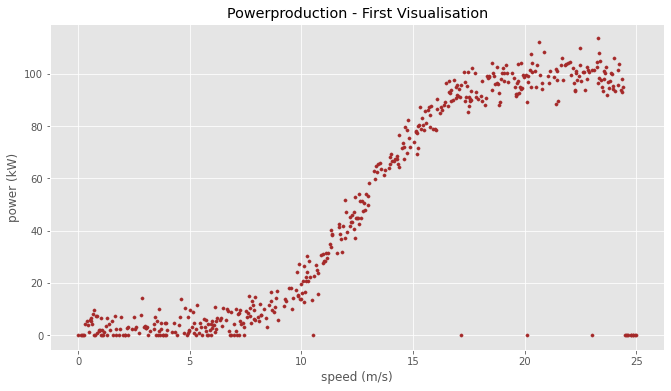

In [24]:
# Plot data on a scatter plot
plt.title('Powerproduction - First Visualisation')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.scatter(pp['speed'], pp['power'], color='brown', marker='o', s=10)

#### Wind Turbine Power Curve
This plot produces a visualisation of the typical wind turbine power curve. The *cut-in* wind speed is at ~7m/s, below which the turbine is producing hardly any power. Between wind speeds of ~7 and ~17m/s the power ramps up to what is known as the *rated power capacity*. From speeds of ~17m/s the power generated remains constant, right up to ~25m/s, or the *cut-out* wind speed. While there is much potential power in the wind speed above the cut-out speed, the cost of making the turbine capable of producing power under these conditions outweights the benefits of more power being generated [7]. <br>

**note:** *I have assigned the above units of measurement to each variable, kilowatts (kW) for power and meters-per-second (m/s) for wind speed. This makes the explanations throughout the project clearer. These units were deduced following a quick Google search*

#### Outliers
What is also notable from the plot is the presence of seeming outliers in the data. There are a number of observations where no power (0kW) is being generated despite sufficiently high wind speeds. This will be examined in greater detail below.

#### What Predictive Model?
Through visualisation we can get a preliminary indication of what model might best be suited when predicting power output from wind speed. Initial inclinations would suggest that this is a *regression* problem. Given that there are only two variables in the data set, simple linear regression may be an appropriate model although fitting a straight line to the data may not yield the most accurate predictions. It might be more suitable to fit a curve. The variables are clearly *positively* correlated between the *cut-in* speed and the *rated power capacity*. 

##### end section 1

<br>



## 2. Function Approximation: Classification vs Regression

***

The term *Function approximation* describes the problem of approximating a mapping function from input variables to output variables. Generally speaking, function approximation problems can be divided into *classification* and *regression* tasks [8]. Deciding between which of these is most appropriate for the current project is the next step.

#### Classification vs Regression
"Classification predictive modeling is the task of approximating a mapping function (f) from input variables (X) to *discrete* output variables (y)" [9], while the output variables for regression models are *continuous* numeric variables. The aim of the current project is to predict power output from wind speed. As noted above, this is a continuous numeric variable which tells us that regression is an appropriate model/function for this task.

#### Regression
Regression is a statistical method which describes the relationship between a dependent variable and one or more independent variables [10]. Additionally, it is associated with fitting a line (or curve) to the data by plotting the line over the data points to get the best fit [11]. Taking a look data as plotted on a scatter plot, it is clear that we could fit a line (or curve) in order to accurately predict the dependent variable.



##### end section 2

<br>



## 3. Regression with `scikit-learn`

***

`scikit-learn` is a machine learning library for the python programming language. It provides a range of machine learning algorithms and is used widely for the purposes of predictive modelling [12]. In the current project, `scikit-learn`'s `LinearRegression` class will be used to apply a model to the *powerproduction* data set. Additionally, the package provides a number of tools which will be used to prepare the data and evaluate the models created below.

### 3.1 Data preparation

***

Before building the first model, it is necessary to prepare the data to maximise the ultimate accuracy of the predictions. Firstly, I use a function to detect any outliers in order to improve the performance of the models. Second, I split the data set into subsets using the *train-test split* procedure.


#### 3.1.1 Outliers

When training a predictive model, it is important to remove any outliers so that the data we train the model on most accurately represents the situation at hand. The removal of outliers must be handled sensitively and cautiously so as not to misrepresent the data, and because every data set is different, there is often a lack of clearly defined rules around how to deal with them [13].

Prior to removing any identified outliers, let us first see how a simple linear regression (SLR) model performs with the orignial data set. The data is split into training and testing data. This procedure is explored and explained in greater detail below:

In [6]:
# Using original (pp) data set to train model 
speed_df_pp = pp.drop('power',axis='columns')
power_df_pp = pp.drop('speed',axis='columns')

# Train test split
A_Train_pp, A_Test_pp, B_Train_pp, B_Test_pp = train_test_split(speed_df_pp, power_df_pp, test_size = 0.5, random_state=1)

# Generate instance of the LinearRegression class to create model
reg_pp = LinearRegression()

# Call the fit method to train model
reg_pp.fit(A_Train_pp, B_Train_pp)

# Calculate R-squared value for evaluation
score_pp = reg_pp.score(A_Test_pp, B_Test_pp)

# Print score
print(score_pp)

0.7196585822445968


Training the model using the full data set yields a score of **~0.72**. This represents the R-Squared value also known as the *coefficient of determination* [23]. The R-squared value is a 'goodness-of-fit' measure which can give us an indication as to the accuracy of our regression model. The best possible score is 1, while a score of 0 generally represents a worse-fitting line. The R-squared value "indicates the percentage of the variance in the dependent variable that the independent variables explain collectively." [24] It is worth noting that a high R-squared does not necessarily always indicate the best fit [25].

The trained model is then used to make predictions based on the test data. We can use this prediction to plot a line to visualise how well it fits.

<br>

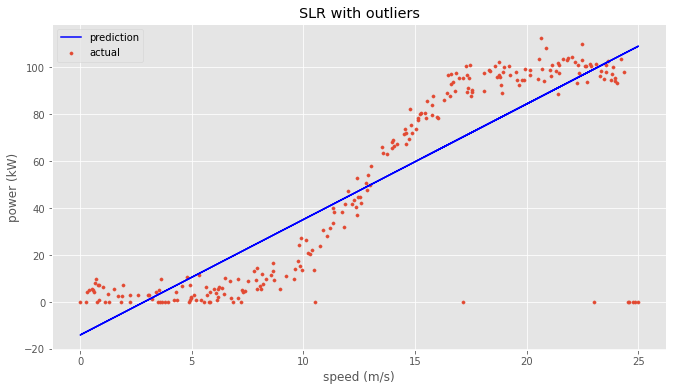

In [7]:
# Use model to make predictions
pp_predict = reg_pp.predict(A_Test_pp)

# Plot fitted line against data for visualisation
plt.scatter(A_Test_pp, B_Test_pp, label='actual', s=10)
plt.plot(A_Test_pp, pp_predict, label='prediction', color='b')

plt.title('SLR with outliers')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

Here we can visualise the output predicted by the model from the test data, plotted as a straight line against the scatter plot of both variables. It quite clearly does not accurately fit the data. 

#### 3.1.2 Outlier detection and removal

As mentioned above, visualisation can give us a strong indication that some of the observations may need to be removed. However, statistical methods can also be used to detect extreme or unlikely values in a data set. 

##### Mahalonibis Distance

In researching outlier detection, much of the online resources appear to deal with *univariate* outliers [14], [15]. Additionally, detection tools available as part of the `scikit-learn` library e.g. `LocalOutlierFactor`, (which uses the nearest neighbours algorithm to detect outliers in a sample) were not suited to the current project. For *multivariate* outliers, a common statistical method of dection is the *Mahalonibis Distance* measure, which is "... widely used distance metric for the detection of multivariate outliers..." [16]. Indeed it has been applied to wind turbine curve modeling by a number of studies (e.g. Pei and Li, 2019) [17]. 

The code for the function below was found on an informative blog post [18] and applies Mahalonibis Distance to the data set to detect outliers. It returns a list of index values for the rows containing outliers as detected by the method. I locate these rows using the `pandas.loc` method and remove them from the data set:

In [8]:
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

# Set variable df to equal pp data set
df = pp

#Robust Mahalonibis Distance
def robust_mahalanobis_method(df):
    #Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ #robust covariance metric
    robust_mean = cov.location_  #robust mean
    inv_covmat = sp.linalg.inv(mcd) #inverse covariance metric
    
    #Robust M-Distance
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))#degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

outliers_mahal_rob, md_rb = robust_mahalanobis_method(df=df)

In [9]:
# Find rows containing outlier indices
pp_outliers = pp.loc[ outliers_mahal_rob , : ]

# Output dataframe of outliers
pp_outliers

,speed,power
340,17.167,0.0
404,20.095,0.0
456,22.998,0.0
490,24.499,0.0
491,24.525,0.0
492,24.575,0.0
493,24.650,0.0
494,24.750,0.0
495,24.775,0.0
496,24.850,0.0


Above is the data frame containing the outlier observations. All the outliers detected have a power value of 0kW. This is what was observed on the scatterplot. Below, I remove them from the data set, creating an updated data set `pp_clean` in the process:

In [10]:
# Remove outliers from data set
pp_clean = pp.drop(outliers_mahal_rob)

In [11]:
# Output statistical summary of updated data frame
pp_clean.describe()

,speed,power
count,487.000000,487.000000
mean,12.294641,49.296287
std,7.077215,41.409933
min,0.000000,0.000000
25%,6.143500,5.769000
50%,12.337000,44.745000
75%,18.380500,93.733500
max,24.399000,113.556000


Text(0, 0.5, 'power (kW)')

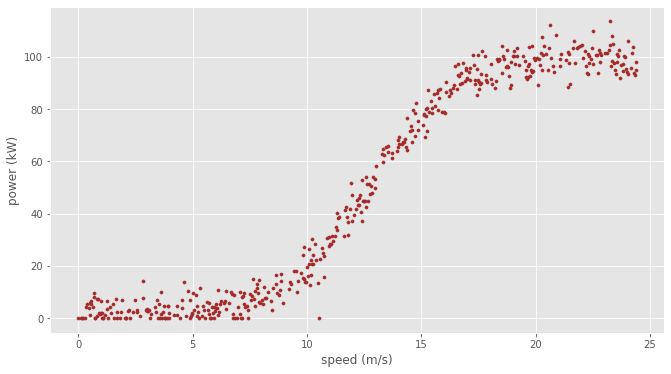

In [12]:
plt.scatter(pp_clean['speed'], pp_clean['power'], color='brown', marker='o', s=10)
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')

The Mahalonibis Distance function detected all but one outlier. I will remove this too for improved performance. Firstly, we view the last 5 observations with power = 0kW:


In [13]:
pp_zero = pp_clean.loc[pp_clean['power'] == 0]
pp_zero.tail()

,speed,power
135,6.857,0.0
136,6.957,0.0
140,7.107,0.0
149,7.432,0.0
208,10.511,0.0


We can see that the outlier is at index 208. This can be removed with the following code:

In [14]:
pp_updated = pp_clean.drop([208])

Now we can train the model with the updated data set:

In [15]:
# Using original (pp) data set to train model 
speed_df_pp_clean = pp_updated.drop('power',axis='columns')
power_df_pp_clean = pp_updated.drop('speed',axis='columns')

# Train test split
x_train, x_test, y_train, y_test = train_test_split(speed_df_pp_clean, power_df_pp_clean, test_size = 0.5, random_state=1)

# Create model
reg_pp_clean = LinearRegression()

# Fit model
reg_pp_clean.fit(x_train, y_train)

# Calculate R-squared value
score_pp_clean = reg_pp_clean.score(x_test, y_test)

# Print score
print(score_pp_clean)

0.9008406364589567


Once the outliers are removed, the model performs better. It yields a score of **~0.90**. 

<br>

We can plot both models side by side for visual comparison:

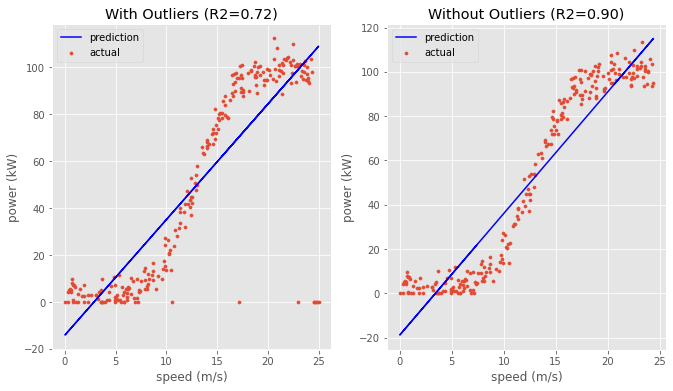

In [16]:
# First subplot
plt.subplot(1, 2, 1)
plt.scatter(A_Test_pp, B_Test_pp, label='actual', s=10)
plt.plot(A_Test_pp, pp_predict, label='prediction', color='b')

plt.title('With Outliers (R2=0.72)')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

# Second subplot
plt.subplot(1, 2, 2)

# Call predict method on test data and plot resulting line
pp_updated_predict = reg_pp_clean.predict(x_test)

plt.scatter(x_test, y_test, label='actual', s=10)
plt.plot(x_test, pp_updated_predict, label='prediction', color='b')

plt.title('Without Outliers (R2=0.90)')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

When viewed side by side, we see that once the outliers are removed the line is a slightly better fit, although it is clear that a straight line does not manage to capture the data accurately in either model.

<br>

#### 3.1.3 Train-test split

This section provides a brief explanation of the *train-test split* procedure as performed in the previous section.

In machine learning, *evaluation* and *validation* are key aspects in measuring how well a model is performing [19]. To ensure that the potential for bias is minimized when evaluating model performance, it is common practice to apply the *train-test split* procedure. This involves training a model by splitting the data into subsets. The *train* subset is used to train the model while the *test* subset is held back in order to test the model's accuracy. Given that we already know the output values for the test subset, we can make informed comparisons between the predicted observed values. (It is worth pointing out that it may not always be appropriate as a technique to increase accuracy of prediction e.g. if the data set is too small [20].) 


<br>

First, the `pp_updated` data set is split by column into two separate subsets, one containing each variable. :

In [17]:
# Create a new dataset containing only values from the speed column
speed_df = pp_updated.drop('power',axis='columns')

#  Print first 10 rows
speed_df.head(10)

,speed
0,0.000
1,0.125
2,0.150
3,0.225
4,0.275
5,0.325
6,0.400
7,0.450
8,0.501
9,0.526


In [18]:
# Create a new dataset containing only values from the power column
power_df = pp_updated.drop('speed',axis='columns')

# Print first 10 rows
power_df.head(10)

,power
0,0.000
1,0.000
2,0.000
3,0.000
4,0.000
5,4.331
6,5.186
7,3.826
8,1.048
9,5.553


<br>

Next, I pass the speed_df and power_df dataframe subsets to `scikit-learn`'s `train_test_split` method and set the parameter *test_size* to 0.5. The test size indicates the size of the train and test sets. Common split percentages include

* Train: 80%, Test: 20%
* Train: 67%, Test: 33%
* Train: 50%, Test: 50% [21]

The values for the train and test subsets are randomly selected, so I set *random_state* to 1. This reproduces the same division of the data each time the program is run. Setting the seed also allows for more representative model comparison as well as parameter comparison when assessing the performance of different models and functions.

**Note: The code below is an exact copy of the procedure as performed above. This is just for demonstration purposes**

In [19]:
# Call train_test_split method on dataframes
x_train, x_test, y_train, y_test = train_test_split(speed_df, power_df, test_size = 0.5, random_state=1)


<br>

### 3.2 Simple linear regression

***

In demonstrating the importance of outlier removal above, I used simple linear regression models. This section provides a brief explanation of simple linear regression before exploring polynomial regression to create a predictive model.

Simple linear regression is "... the simplest case of linear regression with a single independent variable" [22]. Its equation is often expressed as <br> $$ y = \Theta_0 + \Theta_1x $$ <br> It can be applied when the data set contains only two variables - a dependent and independent variable. This is a condition which is filled by the 'powerproduction' data set. 

Once the outliers were removed, the model as trained on the training data produced a score of ~0.90. For certain predictive models, an R-squared value of ~0.90 might be considered satisfactory. However for the current project, it makes sense to attempt to fit a curve to the data to maximise accuracy of predicted output. The following section applies polynomial regression to the data.


<br>

### 3.3 Polynomial regression

***

Visualising the plots above, we can see that a straight line does not follow the curve of the data. This is an example of *under-fitting* [26]. In order to overcome this problem, the complexity of the model needs to be increased. With polynomial regression, we can generate a curve that better captures the data. It involves generating a higher order equation by adding powers to convert features into their higher order terms [27]. The equation for polynomial regression is commonly expressed as: $$ y = \Theta_0 + \Theta_1x + \Theta_2x^2 + \Theta_3x^3 + ... + \Theta_nx^n $$ <br>

`scikit-learn` provides the `PolynomialFeatures` class which enables us to transform features to their higher order terms by setting the degree parameter to the desired power. Then, this model can be trained using the `LinearRegression` class just as above. The code for this is based on an informative *towardsdatascience.com* blog post [28].

First, the training data is converted to numpy arrays. This makes it easier to sort and plot below. Then, an instance of the `PolynomialFeatures` class is created, generating polynomial degrees to the 9th degree. This is the degree value that yields the highest R-Squared score. The `fit_transform` method applies polynomial transformation of degree 9. The transformed feature (wind speed) is then fit to the model and predictions are made based on the test data. 

In [20]:
# Convert train and test subsets to numpy arrays
poly_speed_train = x_train.to_numpy().reshape(-1, 1)
poly_power_train = y_train.to_numpy().reshape(-1, 1)
poly_speed_test  = x_test.to_numpy().reshape(-1, 1)
poly_power_test = y_test.to_numpy().reshape(-1, 1)

# Create PolynomialFeatures class instance with degree=9
poly_features = PolynomialFeatures(degree=9)

# Apply polynomial transformation of degree 9
train_speed = poly_features.fit_transform(poly_speed_train)

# Create instance of LinearRegression class
poly_model = LinearRegression()

# Train the model with training data
poly_model.fit(train_speed, poly_power_train)

# Use the model to predict power output of test data
y_test_predict = poly_model.predict(poly_features.fit_transform(poly_speed_test))

<br>

Using `sciki-learn`'s evaluation metrics, we can calculate the R-squared value as well as the *mean-squared-error* (mse), which is the most commonly used regression loss function [29]:

In [21]:
# Calculate mean squared error 
mse = mean_squared_error(poly_power_test, y_test_predict)

# Calculate coeeficient of determination
r2 = r2_score(poly_power_test, y_test_predict)

# Output reults to the screen
mse, r2

(18.29934798625694, 0.9895079443988561)

With an R-Squared value of **~0.99** we can see that polynomial regression performs significantly better than the simple linear regression models above. The mse is **~18.29**. This will be compared with additional models below.

<br>

When plotted on a graph, it is clear that the curve captures the data much more closely than simple linear regression:

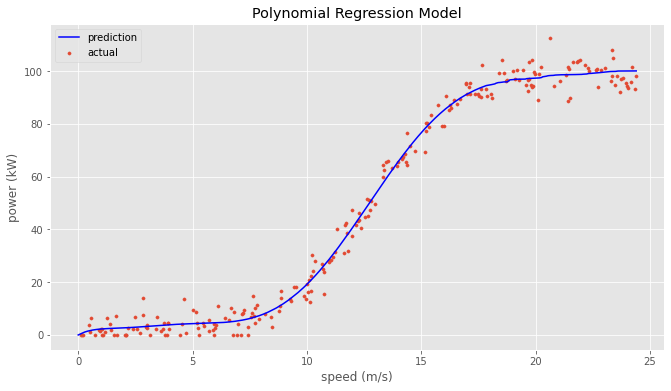

In [22]:
# Plot on scatterplot
plt.scatter(poly_speed_train, poly_power_train, label='actual', s=10)

sorted_poly_speed_test = np.sort(poly_speed_test, 0)
sorted_y_test_predict = np.sort(y_test_predict, 0)


# # Plot line based on model predictions
# plt.plot(sorted_poly_x, sorted_y_test_predict, label='prediction', color='b')
plt.plot(sorted_poly_speed_test, sorted_y_test_predict, label='prediction', color='b')

# Labels
plt.title('Polynomial Regression Model')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

In [23]:
llop

NameError: name 'llop' is not defined

## 4 Neural network - Regression with `keras`

***

Neural networks is one of the most commonly used algorithms in machine learning and it covers a broad range of concepts and techniques [30]. Below, I build a neural network which implements regression to predict wind turbine power output from wind speed input. Depending on the nature of the problem to be solved, neural networks can range from simple, with fewer hidden layers (shallower) and fewer neurons in each layer (narrower), to more complex structures (deeper and wider) [31]. 

When applying a neural network model to a problem, there are a number of such parameters which can be tuned in order to minimize the loss function:

* **Number of hidden layers**: Adding more hidden layers can improve the performance of a neural network
* **Number of neurons**: Increasing the number of neurons in a given layer can also minimize the loss function
* **Number of epochs**: When training a model with input data, the algorithm iterates through epochs (cycles). Depending on the data set, a model may need to run through few or many epochs to minimize the loss function sufficiently [32].
* **Batch size**: This refers to the number of training samples the applied to the algorithm before the model's internal parameters are updated [33]
* **Weight parameter**: The neurons in each layer are connected to each previous and subsequent layer, with each connection assigned a weight. For the neural networks created using Keras, this parameter can be set manually or it can be handled by the internal working of the algorithm via the `kernal_initializer` parameter. In the first step of a neural network, the input value is multiplied by its corresponding weight and this is repeated for each input value and added together (dot product between inputs and weights) [34]
* **Bias**: The bias is added to the dot product between inputs and weights. It "... is necessary to make a robust neural network" [35]. Like the weight parameter, the bias can be assigned manually or handled via the `bias_initializer` parameter in each layer. It can ensure, for example, that the dot product will never return a value of zero, which would happen if the input values were zero in a given data set. Adding the bias term is a convention when building neural networks and is often set to 1 as default e.g. in the case described. This calculation can be represented mathematically as: 
<br>

$$f \left( b + \sum_{i=1}^{n}x_iw_i \right)$$ 

<br>

* **Activation function**: The value from this calculation is then passed through an activation function. 

In [ ]:
#pp = pp[pp.power != 0]
#pp.describe()

In [88]:
# Create neural network with one neuron
def create_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
    
    return model

In [89]:
model = create_model()

In [91]:
model.predict([14])

array([[-2.6648297]], dtype=float32)

In [ ]:


# msk = np.random.rand(len(pp_clean2)) < 0.5
# train = pp_clean2[msk]

# test = pp_clean2[~msk]

In [ ]:
# model.fit(train['speed'], train['power'], epochs=500, batch_size=10)

In [ ]:
# shapes = model.predict(test['speed'])

In [ ]:
# shapes.shape

In [ ]:
# plt.scatter(test['speed'], test['power'], label='actual', s=10)
# plt.plot(test['speed'], model.predict(test['speed']), label='prediction')
# plt.legend()

In [27]:
model.fit(x_train, y_train, epochs=500, batch_size=10)

Epoch 1/500
25/25 [==============================] - 2s 3ms/step - loss: 3243.5160
Epoch 2/500
25/25 [==============================] - 0s 3ms/step - loss: 2029.3023
Epoch 3/500
25/25 [==============================] - 0s 3ms/step - loss: 890.2080
Epoch 4/500
25/25 [==============================] - 0s 3ms/step - loss: 301.6413
Epoch 5/500
25/25 [==============================] - 0s 3ms/step - loss: 293.1427
Epoch 6/500
25/25 [==============================] - 0s 3ms/step - loss: 286.2948
Epoch 7/500
25/25 [==============================] - 0s 3ms/step - loss: 245.1153
Epoch 8/500
25/25 [==============================] - 0s 4ms/step - loss: 235.5072
Epoch 9/500
25/25 [==============================] - 0s 3ms/step - loss: 203.2703
Epoch 10/500
25/25 [==============================] - 0s 3ms/step - loss: 226.3079
Epoch 11/500
25/25 [==============================] - 0s 3ms/step - loss: 183.3324
Epoch 12/500
25/25 [==============================] - 0s 3ms/step - loss: 181.6018
Epoch 13/50

25/25 [==============================] - 0s 2ms/step - loss: 46.8209
Epoch 101/500
25/25 [==============================] - 0s 2ms/step - loss: 49.8126
Epoch 102/500
25/25 [==============================] - 0s 3ms/step - loss: 56.5496
Epoch 103/500
25/25 [==============================] - 0s 3ms/step - loss: 53.6642
Epoch 104/500
25/25 [==============================] - 0s 3ms/step - loss: 42.4507
Epoch 105/500
25/25 [==============================] - 0s 3ms/step - loss: 46.1526
Epoch 106/500
25/25 [==============================] - 0s 3ms/step - loss: 53.5520
Epoch 107/500
25/25 [==============================] - 0s 3ms/step - loss: 47.6544
Epoch 108/500
25/25 [==============================] - 0s 2ms/step - loss: 38.9210
Epoch 109/500
25/25 [==============================] - 0s 2ms/step - loss: 47.5529
Epoch 110/500
25/25 [==============================] - 0s 2ms/step - loss: 54.0752
Epoch 111/500
25/25 [==============================] - 0s 3ms/step - loss: 61.5990
Epoch 112/500
25/2

25/25 [==============================] - 0s 3ms/step - loss: 27.8143
Epoch 199/500
25/25 [==============================] - 0s 3ms/step - loss: 27.0235
Epoch 200/500
25/25 [==============================] - 0s 3ms/step - loss: 26.8952
Epoch 201/500
25/25 [==============================] - 0s 3ms/step - loss: 28.6462
Epoch 202/500
25/25 [==============================] - 0s 3ms/step - loss: 28.1706
Epoch 203/500
25/25 [==============================] - 0s 2ms/step - loss: 32.0135
Epoch 204/500
25/25 [==============================] - 0s 3ms/step - loss: 26.4275
Epoch 205/500
25/25 [==============================] - 0s 3ms/step - loss: 28.8988
Epoch 206/500
25/25 [==============================] - 0s 3ms/step - loss: 27.7388
Epoch 207/500
25/25 [==============================] - 0s 2ms/step - loss: 25.8499
Epoch 208/500
25/25 [==============================] - 0s 2ms/step - loss: 29.6765
Epoch 209/500
25/25 [==============================] - 0s 3ms/step - loss: 25.4733
Epoch 210/500
25/2

25/25 [==============================] - 0s 3ms/step - loss: 26.1952
Epoch 297/500
25/25 [==============================] - 0s 3ms/step - loss: 18.7695
Epoch 298/500
25/25 [==============================] - 0s 3ms/step - loss: 18.8521
Epoch 299/500
25/25 [==============================] - 0s 3ms/step - loss: 18.4188
Epoch 300/500
25/25 [==============================] - 0s 3ms/step - loss: 15.5425
Epoch 301/500
25/25 [==============================] - 0s 3ms/step - loss: 20.6098
Epoch 302/500
25/25 [==============================] - 0s 3ms/step - loss: 17.9099
Epoch 303/500
25/25 [==============================] - 0s 2ms/step - loss: 17.2945
Epoch 304/500
25/25 [==============================] - 0s 2ms/step - loss: 17.8068
Epoch 305/500
25/25 [==============================] - 0s 3ms/step - loss: 22.6814
Epoch 306/500
25/25 [==============================] - 0s 3ms/step - loss: 21.1579
Epoch 307/500
25/25 [==============================] - 0s 3ms/step - loss: 20.2884
Epoch 308/500
25/2

25/25 [==============================] - 0s 3ms/step - loss: 17.1611
Epoch 395/500
25/25 [==============================] - 0s 3ms/step - loss: 18.0102
Epoch 396/500
25/25 [==============================] - 0s 3ms/step - loss: 15.8933
Epoch 397/500
25/25 [==============================] - 0s 3ms/step - loss: 17.7458
Epoch 398/500
25/25 [==============================] - 0s 3ms/step - loss: 17.3942
Epoch 399/500
25/25 [==============================] - 0s 3ms/step - loss: 16.8174
Epoch 400/500
25/25 [==============================] - 0s 3ms/step - loss: 16.9010
Epoch 401/500
25/25 [==============================] - 0s 3ms/step - loss: 18.0380
Epoch 402/500
25/25 [==============================] - 0s 3ms/step - loss: 18.8816
Epoch 403/500
25/25 [==============================] - 0s 2ms/step - loss: 18.9841
Epoch 404/500
25/25 [==============================] - 0s 2ms/step - loss: 16.9549
Epoch 405/500
25/25 [==============================] - 0s 3ms/step - loss: 17.2418
Epoch 406/500
25/2

25/25 [==============================] - 0s 3ms/step - loss: 19.0887
Epoch 493/500
25/25 [==============================] - 0s 3ms/step - loss: 19.7877
Epoch 494/500
25/25 [==============================] - 0s 2ms/step - loss: 18.3786
Epoch 495/500
25/25 [==============================] - 0s 2ms/step - loss: 18.5710
Epoch 496/500
25/25 [==============================] - 0s 3ms/step - loss: 18.3032
Epoch 497/500
25/25 [==============================] - 0s 2ms/step - loss: 20.7826
Epoch 498/500
25/25 [==============================] - 0s 2ms/step - loss: 18.1241
Epoch 499/500
25/25 [==============================] - 0s 2ms/step - loss: 17.0501
Epoch 500/500
25/25 [==============================] - 0s 3ms/step - loss: 20.1591


In [28]:
nn_predict = model.predict(x_test)

nn_predict.shape

(243, 1)

In [29]:
arr_sort = np.sort(nn_predict, axis=0)

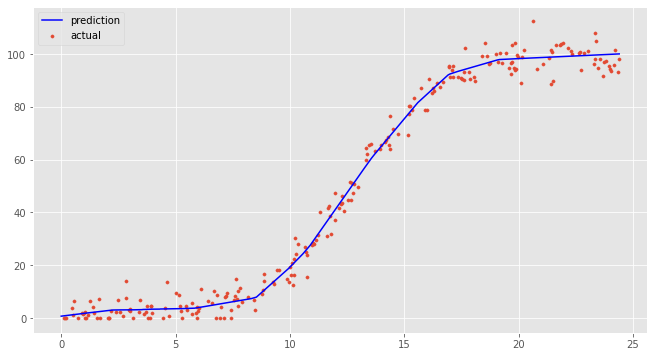

In [30]:
nn_predict = np.sort(nn_predict, axis=0)
A_Test_sort = np.sort(x_test, axis=0)

plt.scatter(x_train, y_train, label='actual', s=10)

# sort_axis_nn = operator.itemgetter(0)
# sorted_zip_nn = sorted(zip(A_Test, nn_predict), key=sort_axis)
# sorted_poly_x_nn, sorted_y_test_predict_nn = zip(*sorted_zip)

plt.plot(A_Test_sort, nn_predict, label='prediction', color='b')
plt.legend()

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________


In [32]:
# model.save('my_model.h5')

In [33]:
model.predict([14])

array([[65.12687]], dtype=float32)

In [34]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

dataset = pp_updated.values
# split into input (X) and output (Y) variables
X = dataset[:,0:1]
Y = dataset[:,1]

def some_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(10, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.01), loss='mean_squared_error')
    
    return model




# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=some_model, epochs=300, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)

Epoch 1/300
44/44 [==============================] - 1s 3ms/step - loss: 4289.9230
Epoch 2/300
44/44 [==============================] - 0s 3ms/step - loss: 4170.4495
Epoch 3/300
44/44 [==============================] - 0s 2ms/step - loss: 3691.5872
Epoch 4/300
44/44 [==============================] - 0s 3ms/step - loss: 3157.8219
Epoch 5/300
44/44 [==============================] - 0s 3ms/step - loss: 2616.7878
Epoch 6/300
44/44 [==============================] - 0s 3ms/step - loss: 2399.5740
Epoch 7/300
44/44 [==============================] - 0s 3ms/step - loss: 1931.2134
Epoch 8/300
44/44 [==============================] - 0s 3ms/step - loss: 1752.5851
Epoch 9/300
44/44 [==============================] - 0s 3ms/step - loss: 1501.0721
Epoch 10/300
44/44 [==============================] - 0s 3ms/step - loss: 1304.3774
Epoch 11/300
44/44 [==============================] - 0s 2ms/step - loss: 1106.3554
Epoch 12/300
44/44 [==============================] - 0s 2ms/step - loss: 990.2960
Ep

44/44 [==============================] - 0s 3ms/step - loss: 18.9578
Epoch 101/300
44/44 [==============================] - 0s 2ms/step - loss: 19.9877
Epoch 102/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9529
Epoch 103/300
44/44 [==============================] - 0s 2ms/step - loss: 20.5624
Epoch 104/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0210
Epoch 105/300
44/44 [==============================] - 0s 3ms/step - loss: 20.2007
Epoch 106/300
44/44 [==============================] - 0s 3ms/step - loss: 17.8893
Epoch 107/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1497
Epoch 108/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8684
Epoch 109/300
44/44 [==============================] - 0s 3ms/step - loss: 18.9944
Epoch 110/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1763
Epoch 111/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1618
Epoch 112/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 17.9181
Epoch 199/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0379
Epoch 200/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2556
Epoch 201/300
44/44 [==============================] - 0s 3ms/step - loss: 18.2390
Epoch 202/300
44/44 [==============================] - 0s 3ms/step - loss: 17.5190
Epoch 203/300
44/44 [==============================] - 0s 3ms/step - loss: 16.8529
Epoch 204/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1693
Epoch 205/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8124
Epoch 206/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2210
Epoch 207/300
44/44 [==============================] - 0s 3ms/step - loss: 16.2114
Epoch 208/300
44/44 [==============================] - 0s 3ms/step - loss: 18.0013
Epoch 209/300
44/44 [==============================] - 0s 3ms/step - loss: 18.5124
Epoch 210/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 16.4213
Epoch 297/300
44/44 [==============================] - 0s 3ms/step - loss: 16.4405
Epoch 298/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4892
Epoch 299/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6667
Epoch 300/300
5/5 [==============================] - 0s 1ms/step - loss: 8.0608
Epoch 1/300
44/44 [==============================] - 1s 2ms/step - loss: 4467.1228
Epoch 2/300
44/44 [==============================] - 0s 2ms/step - loss: 4383.9572
Epoch 3/300
44/44 [==============================] - 0s 3ms/step - loss: 4178.9362
Epoch 4/300
44/44 [==============================] - 0s 3ms/step - loss: 3325.9041
Epoch 5/300
44/44 [==============================] - 0s 3ms/step - loss: 2894.4402
Epoch 6/300
44/44 [==============================] - 0s 3ms/step - loss: 2473.2870
Epoch 7/300
44/44 [==============================] - 0s 3ms/step - loss: 2211.7519
Epoch 8/300
44/44 [==

44/44 [==============================] - 0s 2ms/step - loss: 17.6090
Epoch 95/300
44/44 [==============================] - 0s 3ms/step - loss: 16.9614
Epoch 96/300
44/44 [==============================] - 0s 3ms/step - loss: 20.5598
Epoch 97/300
44/44 [==============================] - 0s 3ms/step - loss: 17.8433
Epoch 98/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1123
Epoch 99/300
44/44 [==============================] - 0s 3ms/step - loss: 19.7356
Epoch 100/300
44/44 [==============================] - 0s 3ms/step - loss: 17.4837
Epoch 101/300
44/44 [==============================] - 0s 3ms/step - loss: 18.0319
Epoch 102/300
44/44 [==============================] - 0s 3ms/step - loss: 18.9534
Epoch 103/300
44/44 [==============================] - 0s 3ms/step - loss: 16.3053
Epoch 104/300
44/44 [==============================] - 0s 3ms/step - loss: 17.6871
Epoch 105/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4534
Epoch 106/300
44/44 [==

44/44 [==============================] - 0s 3ms/step - loss: 17.2968
Epoch 193/300
44/44 [==============================] - 0s 3ms/step - loss: 15.8180
Epoch 194/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1141
Epoch 195/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9808
Epoch 196/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6451
Epoch 197/300
44/44 [==============================] - 0s 3ms/step - loss: 16.9419
Epoch 198/300
44/44 [==============================] - 0s 3ms/step - loss: 15.6930
Epoch 199/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0363
Epoch 200/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1102
Epoch 201/300
44/44 [==============================] - 0s 3ms/step - loss: 17.0208
Epoch 202/300
44/44 [==============================] - 0s 3ms/step - loss: 17.2478
Epoch 203/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2656
Epoch 204/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.7762
Epoch 291/300
44/44 [==============================] - 0s 3ms/step - loss: 14.7806
Epoch 292/300
44/44 [==============================] - 0s 3ms/step - loss: 16.7363
Epoch 293/300
44/44 [==============================] - 0s 3ms/step - loss: 15.9924
Epoch 294/300
44/44 [==============================] - 0s 3ms/step - loss: 15.7346
Epoch 295/300
44/44 [==============================] - 0s 3ms/step - loss: 15.9238
Epoch 296/300
44/44 [==============================] - 0s 3ms/step - loss: 17.3208
Epoch 297/300
44/44 [==============================] - 0s 3ms/step - loss: 17.0080
Epoch 298/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4846
Epoch 299/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5041
Epoch 300/300
5/5 [==============================] - 0s 509us/step - loss: 12.8160
Epoch 1/300
44/44 [==============================] - 2s 3ms/step - loss: 4435.3046
Epoch 2/300
44/44 

44/44 [==============================] - 0s 3ms/step - loss: 19.3143
Epoch 89/300
44/44 [==============================] - 0s 3ms/step - loss: 18.3203
Epoch 90/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4039
Epoch 91/300
44/44 [==============================] - 0s 2ms/step - loss: 19.7697
Epoch 92/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5484
Epoch 93/300
44/44 [==============================] - 0s 3ms/step - loss: 18.7331
Epoch 94/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3936
Epoch 95/300
44/44 [==============================] - 0s 3ms/step - loss: 17.2272
Epoch 96/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6750
Epoch 97/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3028
Epoch 98/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5572
Epoch 99/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6684
Epoch 100/300
44/44 [========

44/44 [==============================] - 0s 3ms/step - loss: 17.8955
Epoch 188/300
44/44 [==============================] - 0s 3ms/step - loss: 17.6019
Epoch 189/300
44/44 [==============================] - 0s 3ms/step - loss: 16.8487
Epoch 190/300
44/44 [==============================] - 0s 3ms/step - loss: 16.1500
Epoch 191/300
44/44 [==============================] - 0s 3ms/step - loss: 17.1782
Epoch 192/300
44/44 [==============================] - 0s 3ms/step - loss: 16.9417
Epoch 193/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8103
Epoch 194/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3830
Epoch 195/300
44/44 [==============================] - 0s 3ms/step - loss: 16.2460
Epoch 196/300
44/44 [==============================] - 0s 3ms/step - loss: 18.5046
Epoch 197/300
44/44 [==============================] - 0s 3ms/step - loss: 15.3588
Epoch 198/300
44/44 [==============================] - 0s 3ms/step - loss: 14.7946
Epoch 199/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 18.8195
Epoch 286/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2042
Epoch 287/300
44/44 [==============================] - 0s 3ms/step - loss: 15.7570
Epoch 288/300
44/44 [==============================] - 0s 3ms/step - loss: 17.8409
Epoch 289/300
44/44 [==============================] - 0s 3ms/step - loss: 16.4387
Epoch 290/300
44/44 [==============================] - 0s 3ms/step - loss: 17.2842
Epoch 291/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6563
Epoch 292/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5158
Epoch 293/300
44/44 [==============================] - 0s 3ms/step - loss: 17.0416
Epoch 294/300
44/44 [==============================] - 0s 3ms/step - loss: 16.5918
Epoch 295/300
44/44 [==============================] - 0s 3ms/step - loss: 16.1083
Epoch 296/300
44/44 [==============================] - 0s 3ms/step - loss: 17.7598
Epoch 297/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 19.3614
Epoch 84/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7476
Epoch 85/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4635
Epoch 86/300
44/44 [==============================] - 0s 3ms/step - loss: 17.3874
Epoch 87/300
44/44 [==============================] - 0s 3ms/step - loss: 19.3381
Epoch 88/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9616
Epoch 89/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2773
Epoch 90/300
44/44 [==============================] - 0s 3ms/step - loss: 17.1026
Epoch 91/300
44/44 [==============================] - 0s 3ms/step - loss: 18.1298
Epoch 92/300
44/44 [==============================] - 0s 3ms/step - loss: 17.1821
Epoch 93/300
44/44 [==============================] - 0s 3ms/step - loss: 16.4590
Epoch 94/300
44/44 [==============================] - 0s 3ms/step - loss: 18.3574
Epoch 95/300
44/44 [=========

44/44 [==============================] - 0s 3ms/step - loss: 15.5279
Epoch 182/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8087
Epoch 183/300
44/44 [==============================] - 0s 3ms/step - loss: 18.9729
Epoch 184/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0719
Epoch 185/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6462
Epoch 186/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2789
Epoch 187/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2605
Epoch 188/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8680
Epoch 189/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9204
Epoch 190/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4748
Epoch 191/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2682
Epoch 192/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2449
Epoch 193/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 15.7674
Epoch 280/300
44/44 [==============================] - 0s 3ms/step - loss: 17.0631
Epoch 281/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3745
Epoch 282/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9953
Epoch 283/300
44/44 [==============================] - 0s 3ms/step - loss: 15.8447
Epoch 284/300
44/44 [==============================] - 0s 3ms/step - loss: 15.3724
Epoch 285/300
44/44 [==============================] - 0s 3ms/step - loss: 17.9869
Epoch 286/300
44/44 [==============================] - 0s 3ms/step - loss: 15.3180
Epoch 287/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0095
Epoch 288/300
44/44 [==============================] - 0s 3ms/step - loss: 16.3450
Epoch 289/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6047
Epoch 290/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8553
Epoch 291/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 18.3807
Epoch 78/300
44/44 [==============================] - 0s 3ms/step - loss: 21.2836
Epoch 79/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5231
Epoch 80/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1675
Epoch 81/300
44/44 [==============================] - 0s 3ms/step - loss: 20.6090
Epoch 82/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5200
Epoch 83/300
44/44 [==============================] - 0s 3ms/step - loss: 17.9462
Epoch 84/300
44/44 [==============================] - 0s 2ms/step - loss: 19.4957
Epoch 85/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7928
Epoch 86/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5113
Epoch 87/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1840
Epoch 88/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7852
Epoch 89/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 17.1415
Epoch 177/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0582
Epoch 178/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1135
Epoch 179/300
44/44 [==============================] - 0s 3ms/step - loss: 15.8939
Epoch 180/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0804
Epoch 181/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8752
Epoch 182/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7350
Epoch 183/300
44/44 [==============================] - 0s 2ms/step - loss: 14.3596
Epoch 184/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9218
Epoch 185/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9447
Epoch 186/300
44/44 [==============================] - 0s 2ms/step - loss: 14.9093
Epoch 187/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1119
Epoch 188/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.1879
Epoch 275/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8399
Epoch 276/300
44/44 [==============================] - 0s 3ms/step - loss: 15.9662
Epoch 277/300
44/44 [==============================] - 0s 3ms/step - loss: 17.2953
Epoch 278/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7684
Epoch 279/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3992
Epoch 280/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1438
Epoch 281/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5918
Epoch 282/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5285
Epoch 283/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5725
Epoch 284/300
44/44 [==============================] - 0s 2ms/step - loss: 15.2545
Epoch 285/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7683
Epoch 286/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 19.5883
Epoch 73/300
44/44 [==============================] - 0s 2ms/step - loss: 20.9776
Epoch 74/300
44/44 [==============================] - 0s 2ms/step - loss: 19.7429
Epoch 75/300
44/44 [==============================] - 0s 2ms/step - loss: 19.9989
Epoch 76/300
44/44 [==============================] - 0s 2ms/step - loss: 21.5838
Epoch 77/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4694
Epoch 78/300
44/44 [==============================] - 0s 2ms/step - loss: 20.9930
Epoch 79/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5082
Epoch 80/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2574
Epoch 81/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1970
Epoch 82/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4128
Epoch 83/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5126
Epoch 84/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 15.0733
Epoch 172/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6241
Epoch 173/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2168
Epoch 174/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1445
Epoch 175/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5803
Epoch 176/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4280
Epoch 177/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5038
Epoch 178/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2094
Epoch 179/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3828
Epoch 180/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0798
Epoch 181/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2173
Epoch 182/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1057
Epoch 183/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.5304
Epoch 270/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7692
Epoch 271/300
44/44 [==============================] - 0s 3ms/step - loss: 17.0161
Epoch 272/300
44/44 [==============================] - 0s 3ms/step - loss: 16.8427
Epoch 273/300
44/44 [==============================] - 0s 3ms/step - loss: 18.2835
Epoch 274/300
44/44 [==============================] - 0s 3ms/step - loss: 19.9585
Epoch 275/300
44/44 [==============================] - 0s 3ms/step - loss: 14.8388
Epoch 276/300
44/44 [==============================] - 0s 3ms/step - loss: 16.2011
Epoch 277/300
44/44 [==============================] - 0s 3ms/step - loss: 15.6694
Epoch 278/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4951
Epoch 279/300
44/44 [==============================] - 0s 2ms/step - loss: 14.1510
Epoch 280/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4835
Epoch 281/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 18.8866
Epoch 68/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5176
Epoch 69/300
44/44 [==============================] - 0s 2ms/step - loss: 20.5256
Epoch 70/300
44/44 [==============================] - 0s 2ms/step - loss: 20.9298
Epoch 71/300
44/44 [==============================] - 0s 2ms/step - loss: 19.8184
Epoch 72/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3223
Epoch 73/300
44/44 [==============================] - 0s 3ms/step - loss: 19.3403
Epoch 74/300
44/44 [==============================] - 0s 2ms/step - loss: 20.3083
Epoch 75/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6286
Epoch 76/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0502
Epoch 77/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0192
Epoch 78/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9783
Epoch 79/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 16.1065
Epoch 167/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3020
Epoch 168/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3178
Epoch 169/300
44/44 [==============================] - 0s 2ms/step - loss: 15.2062
Epoch 170/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0387
Epoch 171/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0350
Epoch 172/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4814
Epoch 173/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1094
Epoch 174/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1347
Epoch 175/300
44/44 [==============================] - 0s 3ms/step - loss: 16.5991
Epoch 176/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5253
Epoch 177/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6885
Epoch 178/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.7294
Epoch 265/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6853
Epoch 266/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9652
Epoch 267/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9117
Epoch 268/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6137
Epoch 269/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0023
Epoch 270/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0024
Epoch 271/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2677
Epoch 272/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9122
Epoch 273/300
44/44 [==============================] - 0s 2ms/step - loss: 14.9020
Epoch 274/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8498
Epoch 275/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3294
Epoch 276/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.7212
Epoch 63/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2009
Epoch 64/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7667
Epoch 65/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9645
Epoch 66/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8812
Epoch 67/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9557
Epoch 68/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1887
Epoch 69/300
44/44 [==============================] - 0s 2ms/step - loss: 14.7187
Epoch 70/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6061
Epoch 71/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4061
Epoch 72/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1518
Epoch 73/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5086
Epoch 74/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 16.8331
Epoch 162/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4669
Epoch 163/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9708
Epoch 164/300
44/44 [==============================] - 0s 2ms/step - loss: 14.3689
Epoch 165/300
44/44 [==============================] - 0s 2ms/step - loss: 14.5288
Epoch 166/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4654
Epoch 167/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8538
Epoch 168/300
44/44 [==============================] - 0s 2ms/step - loss: 14.8678
Epoch 169/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4386
Epoch 170/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9060
Epoch 171/300
44/44 [==============================] - 0s 2ms/step - loss: 14.8109
Epoch 172/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1130
Epoch 173/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.8722
Epoch 260/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7558
Epoch 261/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0895
Epoch 262/300
44/44 [==============================] - 0s 2ms/step - loss: 13.5678
Epoch 263/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3040
Epoch 264/300
44/44 [==============================] - 0s 3ms/step - loss: 15.9628
Epoch 265/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6308
Epoch 266/300
44/44 [==============================] - 0s 2ms/step - loss: 14.6048
Epoch 267/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6630
Epoch 268/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3667
Epoch 269/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1784
Epoch 270/300
44/44 [==============================] - 0s 2ms/step - loss: 14.3870
Epoch 271/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 22.6713
Epoch 57/300
44/44 [==============================] - 0s 3ms/step - loss: 19.8984
Epoch 58/300
44/44 [==============================] - 0s 3ms/step - loss: 19.5340
Epoch 59/300
44/44 [==============================] - 0s 2ms/step - loss: 21.0597
Epoch 60/300
44/44 [==============================] - 0s 2ms/step - loss: 21.2389
Epoch 61/300
44/44 [==============================] - 0s 2ms/step - loss: 21.1112
Epoch 62/300
44/44 [==============================] - 0s 3ms/step - loss: 19.4680
Epoch 63/300
44/44 [==============================] - 0s 3ms/step - loss: 18.2461
Epoch 64/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7689
Epoch 65/300
44/44 [==============================] - 0s 2ms/step - loss: 19.4260
Epoch 66/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3752
Epoch 67/300
44/44 [==============================] - 0s 2ms/step - loss: 21.5585
Epoch 68/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 17.4310
Epoch 156/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0807
Epoch 157/300
44/44 [==============================] - 0s 2ms/step - loss: 14.9411
Epoch 158/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2284
Epoch 159/300
44/44 [==============================] - 0s 2ms/step - loss: 14.7579
Epoch 160/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8895
Epoch 161/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3330
Epoch 162/300
44/44 [==============================] - 0s 2ms/step - loss: 14.4696
Epoch 163/300
44/44 [==============================] - 0s 2ms/step - loss: 14.9566
Epoch 164/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3289
Epoch 165/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4923
Epoch 166/300
44/44 [==============================] - 0s 2ms/step - loss: 14.7314
Epoch 167/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.5243
Epoch 254/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4596
Epoch 255/300
44/44 [==============================] - 0s 2ms/step - loss: 15.1610
Epoch 256/300
44/44 [==============================] - 0s 3ms/step - loss: 15.9591
Epoch 257/300
44/44 [==============================] - 0s 2ms/step - loss: 14.2989
Epoch 258/300
44/44 [==============================] - 0s 2ms/step - loss: 14.3277
Epoch 259/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4341
Epoch 260/300
44/44 [==============================] - 0s 2ms/step - loss: 14.2891
Epoch 261/300
44/44 [==============================] - 0s 2ms/step - loss: 15.1953
Epoch 262/300
44/44 [==============================] - 0s 2ms/step - loss: 15.2304
Epoch 263/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0589
Epoch 264/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0515
Epoch 265/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 20.1916
Epoch 52/300
44/44 [==============================] - 0s 2ms/step - loss: 21.0657
Epoch 53/300
44/44 [==============================] - 0s 3ms/step - loss: 20.4049
Epoch 54/300
44/44 [==============================] - 0s 3ms/step - loss: 20.1190
Epoch 55/300
44/44 [==============================] - 0s 2ms/step - loss: 20.1756
Epoch 56/300
44/44 [==============================] - 0s 3ms/step - loss: 19.2821
Epoch 57/300
44/44 [==============================] - 0s 2ms/step - loss: 20.9609
Epoch 58/300
44/44 [==============================] - 0s 3ms/step - loss: 19.7822
Epoch 59/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2088
Epoch 60/300
44/44 [==============================] - 0s 3ms/step - loss: 19.2045
Epoch 61/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6273
Epoch 62/300
44/44 [==============================] - 0s 3ms/step - loss: 19.9100
Epoch 63/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 14.3213
Epoch 151/300
44/44 [==============================] - 0s 2ms/step - loss: 15.2743
Epoch 152/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1176
Epoch 153/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3006
Epoch 154/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1999
Epoch 155/300
44/44 [==============================] - 0s 2ms/step - loss: 14.5432
Epoch 156/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9857
Epoch 157/300
44/44 [==============================] - 0s 2ms/step - loss: 15.2370
Epoch 158/300
44/44 [==============================] - 0s 3ms/step - loss: 14.7087
Epoch 159/300
44/44 [==============================] - 0s 2ms/step - loss: 14.8951
Epoch 160/300
44/44 [==============================] - 0s 3ms/step - loss: 16.8748
Epoch 161/300
44/44 [==============================] - 0s 2ms/step - loss: 13.8317
Epoch 162/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 14.0771
Epoch 249/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4811
Epoch 250/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3012
Epoch 251/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1511
Epoch 252/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9346
Epoch 253/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7401
Epoch 254/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3486
Epoch 255/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7249
Epoch 256/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3713
Epoch 257/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0021
Epoch 258/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5561
Epoch 259/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4215
Epoch 260/300
44/4

In [35]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

dataset = pp_updated.values
# split into input (X) and output (Y) variables
X = dataset[:,0:1]
Y = dataset[:,1]
# define base model
def baseline_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
#     model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.01), loss='mean_squared_error')
    
    return model




# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=300, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)


Epoch 1/300
44/44 [==============================] - 1s 3ms/step - loss: 4052.7686
Epoch 2/300
44/44 [==============================] - 0s 3ms/step - loss: 1754.8725
Epoch 3/300
44/44 [==============================] - 0s 2ms/step - loss: 688.5117
Epoch 4/300
44/44 [==============================] - 0s 3ms/step - loss: 314.0624
Epoch 5/300
44/44 [==============================] - 0s 2ms/step - loss: 150.3038
Epoch 6/300
44/44 [==============================] - 0s 2ms/step - loss: 86.0475
Epoch 7/300
44/44 [==============================] - 0s 3ms/step - loss: 67.7253
Epoch 8/300
44/44 [==============================] - 0s 2ms/step - loss: 52.8910
Epoch 9/300
44/44 [==============================] - 0s 3ms/step - loss: 50.1581
Epoch 10/300
44/44 [==============================] - 0s 3ms/step - loss: 44.0845
Epoch 11/300
44/44 [==============================] - 0s 2ms/step - loss: 43.9707
Epoch 12/300
44/44 [==============================] - 0s 2ms/step - loss: 37.1199
Epoch 13/300
44/44

44/44 [==============================] - 0s 2ms/step - loss: 19.0481
Epoch 101/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7665
Epoch 102/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5883
Epoch 103/300
44/44 [==============================] - 0s 3ms/step - loss: 18.6196
Epoch 104/300
44/44 [==============================] - 0s 3ms/step - loss: 18.4756
Epoch 105/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4453
Epoch 106/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6108
Epoch 107/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1585
Epoch 108/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5501
Epoch 109/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0011
Epoch 110/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9690
Epoch 111/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7187
Epoch 112/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 17.0166
Epoch 199/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5540
Epoch 200/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9196
Epoch 201/300
44/44 [==============================] - 0s 2ms/step - loss: 20.3160
Epoch 202/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4568
Epoch 203/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2365
Epoch 204/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0591
Epoch 205/300
44/44 [==============================] - 0s 2ms/step - loss: 19.8814
Epoch 206/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5117
Epoch 207/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3919
Epoch 208/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3711
Epoch 209/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2327
Epoch 210/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.0322
Epoch 297/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8984
Epoch 298/300
44/44 [==============================] - 0s 2ms/step - loss: 20.1723
Epoch 299/300
44/44 [==============================] - 0s 2ms/step - loss: 19.2212
Epoch 300/300
5/5 [==============================] - 0s 4ms/step - loss: 7.9144
Epoch 1/300
44/44 [==============================] - 1s 3ms/step - loss: 3619.1698
Epoch 2/300
44/44 [==============================] - 0s 2ms/step - loss: 1731.5897
Epoch 3/300
44/44 [==============================] - 0s 2ms/step - loss: 721.0003
Epoch 4/300
44/44 [==============================] - 0s 2ms/step - loss: 346.4842
Epoch 5/300
44/44 [==============================] - 0s 3ms/step - loss: 187.5432
Epoch 6/300
44/44 [==============================] - 0s 3ms/step - loss: 119.3877
Epoch 7/300
44/44 [==============================] - 0s 2ms/step - loss: 79.3561
Epoch 8/300
44/44 [========

44/44 [==============================] - 0s 2ms/step - loss: 17.6978
Epoch 95/300
44/44 [==============================] - 0s 3ms/step - loss: 19.0056
Epoch 96/300
44/44 [==============================] - 0s 3ms/step - loss: 17.2282
Epoch 97/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5572
Epoch 98/300
44/44 [==============================] - 0s 3ms/step - loss: 17.8854
Epoch 99/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6731
Epoch 100/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7080
Epoch 101/300
44/44 [==============================] - 0s 3ms/step - loss: 18.1771
Epoch 102/300
44/44 [==============================] - 0s 3ms/step - loss: 16.5838
Epoch 103/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5146
Epoch 104/300
44/44 [==============================] - 0s 3ms/step - loss: 17.2386
Epoch 105/300
44/44 [==============================] - 0s 3ms/step - loss: 18.5493
Epoch 106/300
44/44 [==

44/44 [==============================] - 0s 2ms/step - loss: 16.4788
Epoch 193/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2494
Epoch 194/300
44/44 [==============================] - 0s 2ms/step - loss: 19.4304
Epoch 195/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4817
Epoch 196/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4726
Epoch 197/300
44/44 [==============================] - 0s 2ms/step - loss: 19.0311
Epoch 198/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8858
Epoch 199/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2118
Epoch 200/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3990
Epoch 201/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6139
Epoch 202/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9452
Epoch 203/300
44/44 [==============================] - 0s 3ms/step - loss: 16.1166
Epoch 204/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.2766
Epoch 291/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5558
Epoch 292/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3270
Epoch 293/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0358
Epoch 294/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5299
Epoch 295/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5268
Epoch 296/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6328
Epoch 297/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9885
Epoch 298/300
44/44 [==============================] - 0s 3ms/step - loss: 16.4771
Epoch 299/300
44/44 [==============================] - 0s 3ms/step - loss: 16.8662
Epoch 300/300
5/5 [==============================] - 0s 0s/step - loss: 13.0312
Epoch 1/300
44/44 [==============================] - 1s 2ms/step - loss: 3956.4564
Epoch 2/300
44/44 [==

44/44 [==============================] - 0s 2ms/step - loss: 17.8448
Epoch 90/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7442
Epoch 91/300
44/44 [==============================] - 0s 3ms/step - loss: 17.2805
Epoch 92/300
44/44 [==============================] - 0s 3ms/step - loss: 17.5716
Epoch 93/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4133
Epoch 94/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6236
Epoch 95/300
44/44 [==============================] - 0s 3ms/step - loss: 18.4305
Epoch 96/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5218
Epoch 97/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8015
Epoch 98/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8596
Epoch 99/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7254
Epoch 100/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7625
Epoch 101/300
44/44 [=======

44/44 [==============================] - 0s 2ms/step - loss: 15.0706
Epoch 188/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4643
Epoch 189/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2425
Epoch 190/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9996
Epoch 191/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4801
Epoch 192/300
44/44 [==============================] - 0s 2ms/step - loss: 20.3800
Epoch 193/300
44/44 [==============================] - 0s 2ms/step - loss: 19.9233
Epoch 194/300
44/44 [==============================] - 0s 2ms/step - loss: 19.7113
Epoch 195/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9207
Epoch 196/300
44/44 [==============================] - 0s 2ms/step - loss: 20.2690
Epoch 197/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4503
Epoch 198/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4320
Epoch 199/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.3315
Epoch 286/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5238
Epoch 287/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8801
Epoch 288/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8893
Epoch 289/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9114
Epoch 290/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8169
Epoch 291/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4487
Epoch 292/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7655
Epoch 293/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1871
Epoch 294/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9806
Epoch 295/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9173
Epoch 296/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8261
Epoch 297/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 18.1770
Epoch 84/300
44/44 [==============================] - 0s 3ms/step - loss: 17.9140
Epoch 85/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1544
Epoch 86/300
44/44 [==============================] - 0s 3ms/step - loss: 16.7318
Epoch 87/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5881
Epoch 88/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0148
Epoch 89/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8629
Epoch 90/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5642
Epoch 91/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1136
Epoch 92/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0396
Epoch 93/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0950
Epoch 94/300
44/44 [==============================] - 0s 3ms/step - loss: 17.9554
Epoch 95/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 18.3243
Epoch 183/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5185
Epoch 184/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7207
Epoch 185/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7801
Epoch 186/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5038
Epoch 187/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6881
Epoch 188/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2898
Epoch 189/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9636
Epoch 190/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0854
Epoch 191/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2366
Epoch 192/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0882
Epoch 193/300
44/44 [==============================] - 0s 3ms/step - loss: 17.2261
Epoch 194/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.0851
Epoch 281/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9794
Epoch 282/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5040
Epoch 283/300
44/44 [==============================] - 0s 2ms/step - loss: 17.5332
Epoch 284/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2839
Epoch 285/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9320
Epoch 286/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8790
Epoch 287/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6147
Epoch 288/300
44/44 [==============================] - 0s 2ms/step - loss: 17.6403
Epoch 289/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7745
Epoch 290/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7121
Epoch 291/300
44/44 [==============================] - 0s 3ms/step - loss: 15.9482
Epoch 292/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 16.4868
Epoch 80/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3008
Epoch 81/300
44/44 [==============================] - 0s 2ms/step - loss: 14.8742
Epoch 82/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7659
Epoch 83/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9523
Epoch 84/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9968
Epoch 85/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7325
Epoch 86/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3786
Epoch 87/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5544
Epoch 88/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9885
Epoch 89/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0300
Epoch 90/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0912
Epoch 91/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 16.7021
Epoch 179/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8561
Epoch 180/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1479
Epoch 181/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0939
Epoch 182/300
44/44 [==============================] - 0s 3ms/step - loss: 14.8575
Epoch 183/300
44/44 [==============================] - 0s 3ms/step - loss: 18.4860
Epoch 184/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9576
Epoch 185/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0634
Epoch 186/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5127
Epoch 187/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4101
Epoch 188/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9667
Epoch 189/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3771
Epoch 190/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 15.7177
Epoch 277/300
44/44 [==============================] - 0s 2ms/step - loss: 15.2893
Epoch 278/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2521
Epoch 279/300
44/44 [==============================] - 0s 3ms/step - loss: 15.7862
Epoch 280/300
44/44 [==============================] - 0s 3ms/step - loss: 17.0797
Epoch 281/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0995
Epoch 282/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0764
Epoch 283/300
44/44 [==============================] - 0s 3ms/step - loss: 13.8676
Epoch 284/300
44/44 [==============================] - 0s 3ms/step - loss: 17.5712
Epoch 285/300
44/44 [==============================] - 0s 3ms/step - loss: 16.4197
Epoch 286/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9780
Epoch 287/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8613
Epoch 288/300
44/4

Epoch 75/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3426
Epoch 76/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7745
Epoch 77/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2390
Epoch 78/300
44/44 [==============================] - 0s 2ms/step - loss: 18.9488
Epoch 79/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7978
Epoch 80/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3155
Epoch 81/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1421
Epoch 82/300
44/44 [==============================] - 0s 2ms/step - loss: 19.7720
Epoch 83/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1988
Epoch 84/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7643
Epoch 85/300
44/44 [==============================] - 0s 3ms/step - loss: 20.1938
Epoch 86/300
44/44 [==============================] - 0s 2ms/step - loss: 19.1471
Epoch 87/300
44/

44/44 [==============================] - 0s 2ms/step - loss: 16.5310
Epoch 175/300
44/44 [==============================] - 0s 3ms/step - loss: 16.8270
Epoch 176/300
44/44 [==============================] - 0s 3ms/step - loss: 19.7296
Epoch 177/300
44/44 [==============================] - 0s 2ms/step - loss: 19.8398
Epoch 178/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7965
Epoch 179/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3289
Epoch 180/300
44/44 [==============================] - 0s 3ms/step - loss: 17.1755
Epoch 181/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1034
Epoch 182/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3413
Epoch 183/300
44/44 [==============================] - 0s 3ms/step - loss: 18.2218
Epoch 184/300
44/44 [==============================] - 0s 3ms/step - loss: 19.3948
Epoch 185/300
44/44 [==============================] - 0s 3ms/step - loss: 17.1837
Epoch 186/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 19.5115
Epoch 273/300
44/44 [==============================] - 0s 3ms/step - loss: 16.7229
Epoch 274/300
44/44 [==============================] - 0s 2ms/step - loss: 15.5692
Epoch 275/300
44/44 [==============================] - 0s 2ms/step - loss: 14.4839
Epoch 276/300
44/44 [==============================] - 0s 2ms/step - loss: 18.4763
Epoch 277/300
44/44 [==============================] - 0s 3ms/step - loss: 17.2185
Epoch 278/300
44/44 [==============================] - 0s 3ms/step - loss: 15.2947
Epoch 279/300
44/44 [==============================] - 0s 3ms/step - loss: 20.0960
Epoch 280/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5955
Epoch 281/300
44/44 [==============================] - 0s 3ms/step - loss: 16.3511
Epoch 282/300
44/44 [==============================] - 0s 3ms/step - loss: 18.5100
Epoch 283/300
44/44 [==============================] - 0s 2ms/step - loss: 18.7078
Epoch 284/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 18.2998
Epoch 71/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6192
Epoch 72/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1507
Epoch 73/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0208
Epoch 74/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8133
Epoch 75/300
44/44 [==============================] - 0s 3ms/step - loss: 16.9267
Epoch 76/300
44/44 [==============================] - 0s 2ms/step - loss: 14.7961
Epoch 77/300
44/44 [==============================] - 0s 3ms/step - loss: 18.3704
Epoch 78/300
44/44 [==============================] - 0s 3ms/step - loss: 19.2816
Epoch 79/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9948
Epoch 80/300
44/44 [==============================] - 0s 3ms/step - loss: 19.3000
Epoch 81/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8439
Epoch 82/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 15.7803
Epoch 169/300
44/44 [==============================] - 0s 3ms/step - loss: 17.1157
Epoch 170/300
44/44 [==============================] - 0s 3ms/step - loss: 18.2412
Epoch 171/300
44/44 [==============================] - 0s 3ms/step - loss: 16.3942
Epoch 172/300
44/44 [==============================] - 0s 3ms/step - loss: 17.3751
Epoch 173/300
44/44 [==============================] - 0s 3ms/step - loss: 17.2013
Epoch 174/300
44/44 [==============================] - 0s 3ms/step - loss: 16.1722
Epoch 175/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9534
Epoch 176/300
44/44 [==============================] - 0s 3ms/step - loss: 17.4562
Epoch 177/300
44/44 [==============================] - 0s 3ms/step - loss: 17.7405
Epoch 178/300
44/44 [==============================] - 0s 2ms/step - loss: 20.0092
Epoch 179/300
44/44 [==============================] - 0s 2ms/step - loss: 18.8979
Epoch 180/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.3701
Epoch 267/300
44/44 [==============================] - 0s 3ms/step - loss: 16.9300
Epoch 268/300
44/44 [==============================] - 0s 3ms/step - loss: 15.1831
Epoch 269/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0543
Epoch 270/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6045
Epoch 271/300
44/44 [==============================] - 0s 2ms/step - loss: 19.4618
Epoch 272/300
44/44 [==============================] - 0s 2ms/step - loss: 15.1709
Epoch 273/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5245
Epoch 274/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6428
Epoch 275/300
44/44 [==============================] - 0s 2ms/step - loss: 18.6040
Epoch 276/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7672
Epoch 277/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3258
Epoch 278/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 18.0836
Epoch 65/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0712
Epoch 66/300
44/44 [==============================] - 0s 3ms/step - loss: 16.3045
Epoch 67/300
44/44 [==============================] - 0s 3ms/step - loss: 14.0930
Epoch 68/300
44/44 [==============================] - 0s 3ms/step - loss: 18.0632
Epoch 69/300
44/44 [==============================] - 0s 3ms/step - loss: 16.6282
Epoch 70/300
44/44 [==============================] - 0s 3ms/step - loss: 17.5609
Epoch 71/300
44/44 [==============================] - 0s 3ms/step - loss: 18.0506
Epoch 72/300
44/44 [==============================] - 0s 2ms/step - loss: 16.5054
Epoch 73/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7167
Epoch 74/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1308
Epoch 75/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2634
Epoch 76/300
44/44 [=========

44/44 [==============================] - 0s 3ms/step - loss: 16.6987
Epoch 164/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4793
Epoch 165/300
44/44 [==============================] - 0s 2ms/step - loss: 17.8277
Epoch 166/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6859
Epoch 167/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4943
Epoch 168/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7481
Epoch 169/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2348
Epoch 170/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9178
Epoch 171/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1307
Epoch 172/300
44/44 [==============================] - 0s 2ms/step - loss: 17.4984
Epoch 173/300
44/44 [==============================] - 0s 3ms/step - loss: 14.9218
Epoch 174/300
44/44 [==============================] - 0s 2ms/step - loss: 18.5187
Epoch 175/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 15.4007
Epoch 262/300
44/44 [==============================] - 0s 3ms/step - loss: 16.9123
Epoch 263/300
44/44 [==============================] - 0s 3ms/step - loss: 15.7675
Epoch 264/300
44/44 [==============================] - 0s 2ms/step - loss: 15.8114
Epoch 265/300
44/44 [==============================] - 0s 2ms/step - loss: 17.3773
Epoch 266/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0729
Epoch 267/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1120
Epoch 268/300
44/44 [==============================] - 0s 2ms/step - loss: 17.7396
Epoch 269/300
44/44 [==============================] - 0s 2ms/step - loss: 19.5349
Epoch 270/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0955
Epoch 271/300
44/44 [==============================] - 0s 2ms/step - loss: 14.9822
Epoch 272/300
44/44 [==============================] - 0s 2ms/step - loss: 16.1912
Epoch 273/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 17.6300
Epoch 60/300
44/44 [==============================] - 0s 3ms/step - loss: 16.1884
Epoch 61/300
44/44 [==============================] - 0s 3ms/step - loss: 14.9920
Epoch 62/300
44/44 [==============================] - 0s 3ms/step - loss: 16.9529
Epoch 63/300
44/44 [==============================] - 0s 2ms/step - loss: 16.3680
Epoch 64/300
44/44 [==============================] - 0s 3ms/step - loss: 16.6034
Epoch 65/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4109
Epoch 66/300
44/44 [==============================] - 0s 3ms/step - loss: 16.0938
Epoch 67/300
44/44 [==============================] - 0s 3ms/step - loss: 17.4474
Epoch 68/300
44/44 [==============================] - 0s 3ms/step - loss: 16.1011
Epoch 69/300
44/44 [==============================] - 0s 3ms/step - loss: 14.8219
Epoch 70/300
44/44 [==============================] - 0s 3ms/step - loss: 13.8468
Epoch 71/300
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 15.9239
Epoch 159/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2412
Epoch 160/300
44/44 [==============================] - 0s 2ms/step - loss: 14.7123
Epoch 161/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1776
Epoch 162/300
44/44 [==============================] - 0s 3ms/step - loss: 15.5283
Epoch 163/300
44/44 [==============================] - 0s 3ms/step - loss: 15.5139
Epoch 164/300
44/44 [==============================] - 0s 3ms/step - loss: 15.1735
Epoch 165/300
44/44 [==============================] - 0s 3ms/step - loss: 17.1243
Epoch 166/300
44/44 [==============================] - 0s 3ms/step - loss: 16.4094
Epoch 167/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6111
Epoch 168/300
44/44 [==============================] - 0s 2ms/step - loss: 14.6708
Epoch 169/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6525
Epoch 170/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 15.3478
Epoch 257/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6112
Epoch 258/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0786
Epoch 259/300
44/44 [==============================] - 0s 2ms/step - loss: 15.9693
Epoch 260/300
44/44 [==============================] - 0s 2ms/step - loss: 15.3026
Epoch 261/300
44/44 [==============================] - 0s 2ms/step - loss: 15.2726
Epoch 262/300
44/44 [==============================] - 0s 3ms/step - loss: 16.4645
Epoch 263/300
44/44 [==============================] - 0s 3ms/step - loss: 14.4868
Epoch 264/300
44/44 [==============================] - 0s 2ms/step - loss: 13.5120
Epoch 265/300
44/44 [==============================] - 0s 2ms/step - loss: 14.2508
Epoch 266/300
44/44 [==============================] - 0s 2ms/step - loss: 16.2146
Epoch 267/300
44/44 [==============================] - 0s 2ms/step - loss: 13.8237
Epoch 268/300
44/4

44/44 [==============================] - 0s 2ms/step - loss: 16.3837
Epoch 55/300
44/44 [==============================] - 0s 2ms/step - loss: 17.1050
Epoch 56/300
44/44 [==============================] - 0s 2ms/step - loss: 17.2484
Epoch 57/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7529
Epoch 58/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8904
Epoch 59/300
44/44 [==============================] - 0s 3ms/step - loss: 16.3169
Epoch 60/300
44/44 [==============================] - 0s 3ms/step - loss: 16.2562
Epoch 61/300
44/44 [==============================] - 0s 3ms/step - loss: 16.8266
Epoch 62/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7308
Epoch 63/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4440
Epoch 64/300
44/44 [==============================] - 0s 2ms/step - loss: 19.7552
Epoch 65/300
44/44 [==============================] - 0s 2ms/step - loss: 18.3362
Epoch 66/300
44/44 [=========

44/44 [==============================] - 0s 3ms/step - loss: 15.2351
Epoch 154/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6908
Epoch 155/300
44/44 [==============================] - 0s 2ms/step - loss: 17.9048
Epoch 156/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0982
Epoch 157/300
44/44 [==============================] - 0s 2ms/step - loss: 18.2702
Epoch 158/300
44/44 [==============================] - 0s 2ms/step - loss: 17.0088
Epoch 159/300
44/44 [==============================] - 0s 2ms/step - loss: 18.1385
Epoch 160/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4403
Epoch 161/300
44/44 [==============================] - 0s 2ms/step - loss: 16.6388
Epoch 162/300
44/44 [==============================] - 0s 2ms/step - loss: 19.3636
Epoch 163/300
44/44 [==============================] - 0s 2ms/step - loss: 16.8827
Epoch 164/300
44/44 [==============================] - 0s 2ms/step - loss: 15.0900
Epoch 165/300
44/4

44/44 [==============================] - 0s 3ms/step - loss: 14.1501
Epoch 252/300
44/44 [==============================] - 0s 3ms/step - loss: 16.1452
Epoch 253/300
44/44 [==============================] - 0s 2ms/step - loss: 18.0850
Epoch 254/300
44/44 [==============================] - 0s 2ms/step - loss: 15.6765
Epoch 255/300
44/44 [==============================] - 0s 2ms/step - loss: 15.4954
Epoch 256/300
44/44 [==============================] - 0s 3ms/step - loss: 17.9013
Epoch 257/300
44/44 [==============================] - 0s 2ms/step - loss: 16.4982
Epoch 258/300
44/44 [==============================] - 0s 2ms/step - loss: 16.7800
Epoch 259/300
44/44 [==============================] - 0s 2ms/step - loss: 14.8569
Epoch 260/300
44/44 [==============================] - 0s 2ms/step - loss: 16.9380
Epoch 261/300
44/44 [==============================] - 0s 2ms/step - loss: 15.7838
Epoch 262/300
44/44 [==============================] - 0s 2ms/step - loss: 16.0634
Epoch 263/300
44/4

In [36]:

def another_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
#     model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.01), loss='mean_squared_error')
    
    return model







# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=another_model, epochs=100, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)

Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 4158.8258
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 1310.1079
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 129.3017
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 120.2225
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 109.9781
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 119.1147
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 97.7048
Epoch 8/100
44/44 [==============================] - 0s 2ms/step - loss: 101.0901
Epoch 9/100
44/44 [==============================] - 0s 2ms/step - loss: 86.2126
Epoch 10/100
44/44 [==============================] - 0s 3ms/step - loss: 83.4001
Epoch 11/100
44/44 [==============================] - 0s 2ms/step - loss: 75.0674
Epoch 12/100
44/44 [==============================] - 0s 2ms/step - loss: 68.6305
Epoch 13/100
44/

5/5 [==============================] - 0s 0s/step - loss: 10.6669
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 4564.5327
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 1911.5042
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 132.5474
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 117.7248
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 107.1421
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 119.0781
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 119.7910
Epoch 8/100
44/44 [==============================] - 0s 3ms/step - loss: 118.3923
Epoch 9/100
44/44 [==============================] - 0s 2ms/step - loss: 122.5482
Epoch 10/100
44/44 [==============================] - 0s 2ms/step - loss: 110.2142
Epoch 11/100
44/44 [==============================] - 0s 2ms/step - loss: 93.7184
Epoch 12/100
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 20.0920
Epoch 100/100
5/5 [==============================] - 0s 4ms/step - loss: 13.7529
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 4190.0500
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 1781.5151
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 124.8317
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 116.6470
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 113.2887
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 115.1108
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 104.6313
Epoch 8/100
44/44 [==============================] - 0s 2ms/step - loss: 101.7934
Epoch 9/100
44/44 [==============================] - 0s 2ms/step - loss: 95.0144
Epoch 10/100
44/44 [==============================] - 0s 3ms/step - loss: 93.5926
Epoch 11/100
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 17.6156
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 19.7766
Epoch 100/100
5/5 [==============================] - 0s 4ms/step - loss: 14.2221
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 4392.9266
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 1729.9348
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 124.3547
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 106.3967
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 107.8102
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 117.9035
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 102.6579
Epoch 8/100
44/44 [==============================] - 0s 3ms/step - loss: 104.7857
Epoch 9/100
44/44 [==============================] - 0s 2ms/step - loss: 105.8025
Epoch 10/100
44/44 [========

44/44 [==============================] - 0s 2ms/step - loss: 32.3118
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 32.1310
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 33.8291
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 31.3068
Epoch 100/100
5/5 [==============================] - 0s 950us/step - loss: 58.6380
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 3939.9917
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 1651.5465
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 128.7504
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 132.9953
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 125.1515
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 131.2818
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 114.9541
Epoch 8/100
44/44 [=======

44/44 [==============================] - 0s 2ms/step - loss: 19.1608
Epoch 96/100
44/44 [==============================] - 0s 3ms/step - loss: 17.2496
Epoch 97/100
44/44 [==============================] - 0s 3ms/step - loss: 18.4456
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 18.9088
Epoch 99/100
44/44 [==============================] - 0s 3ms/step - loss: 18.3913
Epoch 100/100
5/5 [==============================] - 0s 3ms/step - loss: 23.7679
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 3872.7449
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 1029.0034
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 140.6934
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 114.1492
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 117.4032
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 109.2285
Epoch 7/100
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 17.0832
Epoch 95/100
44/44 [==============================] - 0s 2ms/step - loss: 16.3886
Epoch 96/100
44/44 [==============================] - 0s 3ms/step - loss: 18.1596
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 17.8195
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 19.2568
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 17.1046
Epoch 100/100
5/5 [==============================] - 0s 4ms/step - loss: 24.1169
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 3815.8287
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 961.3144
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 101.9764
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 93.4345
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 92.4187
Epoch 6/100
44/44 [============

44/44 [==============================] - 0s 2ms/step - loss: 18.7917
Epoch 94/100
44/44 [==============================] - 0s 2ms/step - loss: 17.5528
Epoch 95/100
44/44 [==============================] - 0s 2ms/step - loss: 19.7279
Epoch 96/100
44/44 [==============================] - 0s 2ms/step - loss: 18.3256
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 18.9804
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 20.2610
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 18.2026
Epoch 100/100
5/5 [==============================] - 0s 579us/step - loss: 16.5229
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 3206.0272
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 1183.4496
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 116.7180
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 93.2394
Epoch 5/100
44/44 [========

44/44 [==============================] - 0s 2ms/step - loss: 14.8221
Epoch 93/100
44/44 [==============================] - 0s 2ms/step - loss: 17.0620
Epoch 94/100
44/44 [==============================] - 0s 2ms/step - loss: 17.3247
Epoch 95/100
44/44 [==============================] - 0s 2ms/step - loss: 17.5585
Epoch 96/100
44/44 [==============================] - 0s 3ms/step - loss: 16.0771
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 16.4900
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 15.9883
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 17.8482
Epoch 100/100
5/5 [==============================] - 0s 0s/step - loss: 28.4141
Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 3505.7090
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 1255.7561
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 150.0417
Epoch 4/100
44/44 [==========

44/44 [==============================] - 0s 2ms/step - loss: 19.0401
Epoch 92/100
44/44 [==============================] - 0s 3ms/step - loss: 17.4500
Epoch 93/100
44/44 [==============================] - 0s 3ms/step - loss: 15.6296
Epoch 94/100
44/44 [==============================] - 0s 3ms/step - loss: 17.0095
Epoch 95/100
44/44 [==============================] - 0s 3ms/step - loss: 15.8098
Epoch 96/100
44/44 [==============================] - 0s 3ms/step - loss: 16.8989
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 16.4788
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 16.7400
Epoch 99/100
44/44 [==============================] - 0s 3ms/step - loss: 17.9462
Epoch 100/100
5/5 [==============================] - 0s 3ms/step - loss: 24.7481
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 3266.3428
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 1237.3469
Epoch 3/100
44/44 [=========

44/44 [==============================] - 0s 2ms/step - loss: 19.1977
Epoch 91/100
44/44 [==============================] - 0s 2ms/step - loss: 20.6000
Epoch 92/100
44/44 [==============================] - 0s 2ms/step - loss: 18.1877
Epoch 93/100
44/44 [==============================] - 0s 2ms/step - loss: 18.6755
Epoch 94/100
44/44 [==============================] - 0s 2ms/step - loss: 19.4941
Epoch 95/100
44/44 [==============================] - 0s 3ms/step - loss: 19.7503
Epoch 96/100
44/44 [==============================] - 0s 2ms/step - loss: 18.8503
Epoch 97/100
44/44 [==============================] - 0s 2ms/step - loss: 16.3673
Epoch 98/100
44/44 [==============================] - 0s 2ms/step - loss: 22.2513
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 18.0283
Epoch 100/100
5/5 [==============================] - 0s 0s/step - loss: 93.8734


In [40]:
# Create neural network with one neuron
def create_model2():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(100, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
    
    return model

estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=create_model, epochs=100, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)

Epoch 1/100
44/44 [==============================] - 1s 2ms/step - loss: 4402.1178
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 3859.1542
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 3703.9656
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 3045.5290
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 3013.0401
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 2727.5680
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 2665.5826
Epoch 8/100
44/44 [==============================] - 0s 3ms/step - loss: 2465.7281
Epoch 9/100
44/44 [==============================] - 0s 3ms/step - loss: 2330.2018
Epoch 10/100
44/44 [==============================] - 0s 2ms/step - loss: 2350.4780
Epoch 11/100
44/44 [==============================] - 0s 3ms/step - loss: 2146.6919
Epoch 12/100
44/44 [==============================] - 0s 3ms/step - loss: 2031.5879
E

5/5 [==============================] - 0s 0s/step - loss: 8.0541
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 4070.5891
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 3549.8029
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 3351.8752
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 3037.9848
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 2949.3238
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 2672.8006
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 2454.9477
Epoch 8/100
44/44 [==============================] - 0s 2ms/step - loss: 2562.6266
Epoch 9/100
44/44 [==============================] - 0s 3ms/step - loss: 2358.0837
Epoch 10/100
44/44 [==============================] - 0s 3ms/step - loss: 2210.6315
Epoch 11/100
44/44 [==============================] - 0s 3ms/step - loss: 2047.3613
Epoch 12/100
44/44 [

44/44 [==============================] - 0s 3ms/step - loss: 17.7459
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 17.8119
Epoch 100/100
5/5 [==============================] - 0s 3ms/step - loss: 12.5762
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 4480.3432
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 3621.9196
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 3515.3521
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 3082.4341
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 2793.7978
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 2756.2318
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 2493.5023
Epoch 8/100
44/44 [==============================] - 0s 3ms/step - loss: 2508.6263
Epoch 9/100
44/44 [==============================] - 0s 2ms/step - loss: 2436.7036
Epoch 10/100
44/44 [=

44/44 [==============================] - 0s 3ms/step - loss: 17.8346
Epoch 97/100
44/44 [==============================] - 0s 3ms/step - loss: 17.1754
Epoch 98/100
44/44 [==============================] - 0s 3ms/step - loss: 18.7407
Epoch 99/100
44/44 [==============================] - 0s 3ms/step - loss: 17.8039
Epoch 100/100
5/5 [==============================] - 1s 3ms/step - loss: 12.1071
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 4504.2411
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 3998.4353
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 3478.4499
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 3415.3720
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 2824.2095
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 2931.1279
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 2754.2342
Epoch 8/100
44/44 [====

44/44 [==============================] - 0s 3ms/step - loss: 17.0634
Epoch 95/100
44/44 [==============================] - 0s 3ms/step - loss: 16.2329
Epoch 96/100
44/44 [==============================] - 0s 3ms/step - loss: 18.1816
Epoch 97/100
44/44 [==============================] - 0s 3ms/step - loss: 18.9456
Epoch 98/100
44/44 [==============================] - 0s 3ms/step - loss: 16.8771
Epoch 99/100
44/44 [==============================] - 0s 3ms/step - loss: 15.5498
Epoch 100/100
5/5 [==============================] - 0s 4ms/step - loss: 14.4410
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 4507.9627
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 3482.7097
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 3364.9668
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 3373.9350
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 3147.2230
Epoch 6/100
44/44 [======

44/44 [==============================] - 0s 3ms/step - loss: 16.7086
Epoch 93/100
44/44 [==============================] - 0s 3ms/step - loss: 16.2770
Epoch 94/100
44/44 [==============================] - 0s 3ms/step - loss: 17.2765
Epoch 95/100
44/44 [==============================] - 0s 3ms/step - loss: 17.1429
Epoch 96/100
44/44 [==============================] - 0s 3ms/step - loss: 15.6573
Epoch 97/100
44/44 [==============================] - 0s 3ms/step - loss: 15.5208
Epoch 98/100
44/44 [==============================] - 0s 3ms/step - loss: 16.0495
Epoch 99/100
44/44 [==============================] - 0s 3ms/step - loss: 18.5893
Epoch 100/100
5/5 [==============================] - 0s 3ms/step - loss: 23.4363
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 3837.1730
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 3256.1674
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 3605.0121
Epoch 4/100
44/44 [========

44/44 [==============================] - 0s 3ms/step - loss: 16.8925
Epoch 91/100
44/44 [==============================] - 0s 3ms/step - loss: 15.2800
Epoch 92/100
44/44 [==============================] - 0s 3ms/step - loss: 17.3676
Epoch 93/100
44/44 [==============================] - 0s 3ms/step - loss: 16.3011
Epoch 94/100
44/44 [==============================] - 0s 3ms/step - loss: 18.3851
Epoch 95/100
44/44 [==============================] - 0s 3ms/step - loss: 16.6352
Epoch 96/100
44/44 [==============================] - 0s 3ms/step - loss: 16.7174
Epoch 97/100
44/44 [==============================] - 0s 3ms/step - loss: 18.4075
Epoch 98/100
44/44 [==============================] - 0s 3ms/step - loss: 17.1747
Epoch 99/100
44/44 [==============================] - 0s 2ms/step - loss: 16.1124
Epoch 100/100
5/5 [==============================] - 0s 4ms/step - loss: 15.3894
Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 3782.7876
Epoch 2/100
44/44 [==========

44/44 [==============================] - 0s 3ms/step - loss: 16.7054
Epoch 89/100
44/44 [==============================] - 0s 3ms/step - loss: 15.6228
Epoch 90/100
44/44 [==============================] - 0s 3ms/step - loss: 15.6347
Epoch 91/100
44/44 [==============================] - 0s 3ms/step - loss: 15.4145
Epoch 92/100
44/44 [==============================] - 0s 3ms/step - loss: 16.5882
Epoch 93/100
44/44 [==============================] - 0s 3ms/step - loss: 17.8246
Epoch 94/100
44/44 [==============================] - 0s 3ms/step - loss: 16.7780
Epoch 95/100
44/44 [==============================] - 0s 3ms/step - loss: 18.1612
Epoch 96/100
44/44 [==============================] - 0s 3ms/step - loss: 15.9225
Epoch 97/100
44/44 [==============================] - 0s 3ms/step - loss: 17.3591
Epoch 98/100
44/44 [==============================] - 0s 3ms/step - loss: 18.5839
Epoch 99/100
44/44 [==============================] - 0s 3ms/step - loss: 17.0875
Epoch 100/100
5/5 [==========

44/44 [==============================] - 0s 3ms/step - loss: 16.1215
Epoch 87/100
44/44 [==============================] - 0s 3ms/step - loss: 14.9359
Epoch 88/100
44/44 [==============================] - 0s 3ms/step - loss: 14.8204
Epoch 89/100
44/44 [==============================] - 0s 3ms/step - loss: 17.5703
Epoch 90/100
44/44 [==============================] - 0s 3ms/step - loss: 17.2490
Epoch 91/100
44/44 [==============================] - 0s 3ms/step - loss: 15.6070
Epoch 92/100
44/44 [==============================] - 0s 3ms/step - loss: 16.7825
Epoch 93/100
44/44 [==============================] - 0s 3ms/step - loss: 16.9070
Epoch 94/100
44/44 [==============================] - 0s 3ms/step - loss: 16.2131
Epoch 95/100
44/44 [==============================] - 0s 3ms/step - loss: 16.7612
Epoch 96/100
44/44 [==============================] - 0s 3ms/step - loss: 14.9589
Epoch 97/100
44/44 [==============================] - 0s 3ms/step - loss: 15.8962
Epoch 98/100
44/44 [=========

44/44 [==============================] - 0s 3ms/step - loss: 15.9027
Epoch 85/100
44/44 [==============================] - 0s 3ms/step - loss: 15.0854
Epoch 86/100
44/44 [==============================] - 0s 3ms/step - loss: 14.7785
Epoch 87/100
44/44 [==============================] - 0s 3ms/step - loss: 16.9820
Epoch 88/100
44/44 [==============================] - 0s 3ms/step - loss: 14.5534
Epoch 89/100
44/44 [==============================] - 0s 3ms/step - loss: 15.5541
Epoch 90/100
44/44 [==============================] - 0s 3ms/step - loss: 15.3410
Epoch 91/100
44/44 [==============================] - 0s 3ms/step - loss: 17.6846
Epoch 92/100
44/44 [==============================] - 0s 3ms/step - loss: 16.4095
Epoch 93/100
44/44 [==============================] - 0s 3ms/step - loss: 14.9510
Epoch 94/100
44/44 [==============================] - 0s 3ms/step - loss: 14.4753
Epoch 95/100
44/44 [==============================] - 0s 3ms/step - loss: 16.2200
Epoch 96/100
44/44 [=========

44/44 [==============================] - 0s 3ms/step - loss: 16.4459
Epoch 83/100
44/44 [==============================] - 0s 3ms/step - loss: 14.2524
Epoch 84/100
44/44 [==============================] - 0s 2ms/step - loss: 16.4199
Epoch 85/100
44/44 [==============================] - 0s 3ms/step - loss: 16.1836
Epoch 86/100
44/44 [==============================] - 0s 3ms/step - loss: 16.4136
Epoch 87/100
44/44 [==============================] - 0s 3ms/step - loss: 18.1739
Epoch 88/100
44/44 [==============================] - 0s 3ms/step - loss: 18.0604
Epoch 89/100
44/44 [==============================] - 0s 3ms/step - loss: 15.7574
Epoch 90/100
44/44 [==============================] - 0s 3ms/step - loss: 16.6206
Epoch 91/100
44/44 [==============================] - 0s 3ms/step - loss: 15.7086
Epoch 92/100
44/44 [==============================] - 0s 3ms/step - loss: 17.2189
Epoch 93/100
44/44 [==============================] - 0s 3ms/step - loss: 16.0444
Epoch 94/100
44/44 [=========

In [ ]:
# 1 layer, sigmoid, 100 epochs, lr=0.01 = 18.19
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std())) 

In [ ]:
# 1 layer, sigmoid, 300 epochs, lr=0.001 = 17.80, 17.35
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
# 1 layer, sigmoid, 300 epochs, lr=0.01 - 16.98
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
# 1 layer, relu, 100 epochs, lr=0.01- 17.79, 21.94, 48.13
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
# relu, 10 units, 100 epochs, lr=0.01 = 84.82
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
# create_model (adding extra layer doesn't make a difference) - 17.43
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [41]:
create_model2 = create_model()

In [42]:
create_model2.fit(x_train, y_train, epochs=100, batch_size=10)

Epoch 1/100
25/25 [==============================] - 1s 3ms/step - loss: 3807.9034
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 3445.7556
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 3234.2917
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 3277.2128
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 2748.4900
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 2863.8747
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 2628.5922
Epoch 8/100
25/25 [==============================] - 0s 3ms/step - loss: 2626.0774
Epoch 9/100
25/25 [==============================] - 0s 3ms/step - loss: 2548.8607
Epoch 10/100
25/25 [==============================] - 0s 2ms/step - loss: 2691.5972
Epoch 11/100
25/25 [==============================] - 0s 3ms/step - loss: 2672.0825
Epoch 12/100
25/25 [==============================] - 0s 3ms/step - loss: 2224.6736
E

25/25 [==============================] - 0s 3ms/step - loss: 21.7107
Epoch 100/100
25/25 [==============================] - 0s 3ms/step - loss: 22.6343


In [102]:
model.predict([99])

array([[-16.200027]], dtype=float32)

In [44]:
baseline_model = baseline_model()
baseline_model.fit(x_train, y_train, epochs=100, batch_size=10)

Epoch 1/100
25/25 [==============================] - 1s 3ms/step - loss: 3632.8808
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 2064.6492
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 1543.4011
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 1074.2210
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 952.7918
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 696.0040
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 545.4795
Epoch 8/100
25/25 [==============================] - 0s 3ms/step - loss: 412.9737
Epoch 9/100
25/25 [==============================] - 0s 3ms/step - loss: 309.0546
Epoch 10/100
25/25 [==============================] - 0s 2ms/step - loss: 257.4961
Epoch 11/100
25/25 [==============================] - 0s 3ms/step - loss: 181.4379
Epoch 12/100
25/25 [==============================] - 0s 3ms/step - loss: 183.1525
Epoch 13/

25/25 [==============================] - 0s 2ms/step - loss: 19.2177


In [96]:
float(baseline_model.predict([14]))


63.90704345703125

In [97]:
def model_test(wind_speed):
    
    """
    Returns a list of predicted wind turbine power values from an array of wind speed inputs
    """
    
    # Initialise empty list
    power_prediction = []
    
    # Loop through wind speed array
    for i in range(len(wind_speed)):
        if wind_speed[i] >= 24.499 or wind_speed[i] < 0.3: # return 0.000 for values above 24.499 and below 0.3
            power_prediction.append(0.0)
        else:
            #baseline_model.predict(wind_speed[i])
            power_prediction.append(float(baseline_model.predict(wind_speed)[i])) # final predictive model
    
    return power_prediction

In [98]:
x_test1 = x_test.reset_index()

In [99]:
model_test(ho)

[0.0, 63.90704345703125, 0.0, 0.0]

In [78]:
ho = [0.1, 14, 0.2, 25]
ho = np.array(ho)
ho[1]

14.0

In [82]:
baseline_model.predict(ho)[0]

array([2.4905875], dtype=float32)

In [101]:
model_test(pp.speed)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.4363551139831543,
 2.42020583152771,
 2.4099912643432617,
 2.4000401496887207,
 2.3953373432159424,
 2.39074969291687,
 2.3862760066986084,
 2.377683401107788,
 2.369563102722168,
 2.365682601928711,
 2.3619225025177,
 2.3582863807678223,
 2.351377248764038,
 2.348107099533081,
 2.344963550567627,
 2.3362865447998047,
 2.3336474895477295,
 2.3311355113983154,
 2.32875394821167,
 2.326502561569214,
 2.324378490447998,
 2.3223860263824463,
 2.320524215698242,
 2.317199468612671,
 2.3121514320373535,
 2.3112285137176514,
 2.310438394546509,
 2.3086516857147217,
 2.308551073074341,
 2.309094190597534,
 2.3101577758789062,
 2.3139724731445312,
 2.315281867980957,
 2.3167312145233154,
 2.326118230819702,
 2.3308732509613037,
 2.333466053009033,
 2.3485705852508545,
 2.3556125164031982,
 2.359347105026245,
 2.3713998794555664,
 2.380141019821167,
 2.384723424911499,
 2.415132522583008,
 2.432189702987671,
 2.4507038593292236,
 2.457059144973755,
 2.49078488349

In [49]:
len(pp.speed)

500

In [ ]:
np.random.seed(0)
x = 2 - 3 * np.random.normal(0, 1, 20)
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(-3, 3, 20)

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
model2 = GradientBoostingRegressor(random_state=0).fit(A_Train, B_Train.values.ravel())

print(model2.score(A_Train, B_Train))

print(model2.score(A_Test, B_Test))
pred = model2.predict(A_Test)
pred = np.sort(pred, 0)

In [ ]:

from sklearn.ensemble import RandomForestRegressor
model3 = RandomForestRegressor(random_state=0).fit(A_Train, B_Train.values.ravel())
model3.score(A_Train, B_Train)

model3.score(A_Test, B_Test)
pred2 = model3.predict(A_Test)
pred2 = np.sort(pred2, 0)

In [ ]:
# # Use model to make predictions
# pp_predict = reg_pp.predict(A_Test_pp)

# Plot fitted line against data for visualisation
plt.scatter(A_Test, B_Test, label='actual', s=10)
plt.plot(A_Test, pred2, label='prediction', color='b')

plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

### References

[1] w3schools.com; Numpy Introduction; https://www.w3schools.com/python/numpy_intro.asp <br>
[2] w3schools.com; Pandas Tutorial https://www.w3schools.com/python/pandas_tutorial.asp <br>
[3] w3schools.com; Matplotlib Pyplot; https://www.w3schools.com/python/matplotlib_pyplot.asp <br>
[4] wikipedia.org; scikit_learn https://en.wikipedia.org/wiki/Scikit-learn <br>
[5] tensorflow.org; https://www.tensorflow.org/ <br>
[6] keras.io; https://keras.io/ <br>
[7] youtube.com; Wind Turbine Power Curve description; https://www.youtube.com/watch?v=8tNOL4ZL9Do <br>
[8] Brownlee, J.; Difference Between Classification and Regression in Machine Learning https://machinelearningmastery.com/classification-versus-regression-in-machine-learning/ <br>
[9] *Ibid* <br>
[10] Wikipedia.org; Regression analysis; https://en.wikipedia.org/wiki/Regression_analysis <br>
[11] yale.edu; Linear Regression; http://www.stat.yale.edu/Courses/1997-98/101/linreg.htm <br>
[12] wikipdeia.org; scikit-learn; https://en.wikipedia.org/wiki/Scikit-learn <br>
[13] realpython.com; Split Your Dataset With scikit-learn's train_test_split(); https://realpython.com/train-test-split-python-data/ <br>
[14] machinelearningmastery.com; Train-Test Split for Evaluating Machine Learning Algorithms; https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/ <br>
[15] *Ibid* <br>
[16] Detecting And Treating Outliers In Python — Part 2; https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 <br>
[17] Pei, S. and Li, P., 2019; Wind Turbine Power Curve Modeling with a Hybrid Machine Learning Technique; https://www.researchgate.net/publication/337325612_Wind_Turbine_Power_Curve_Modeling_with_a_Hybrid_Machine_Learning_Technique <br>
[18] Detecting And Treating Outliers In Python — Part 2; https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 <br>
[19] Brownlee, J; How to Remove Outliers for Machine Learning; https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/ <br>
[20] *Ibid* <br>
[21] Frost, J; 5 Ways to Find Outliers in Your Data; https://statisticsbyjim.com/basics/outliers/ <br>
[22] realpython.com; Linear Regression in Python; https://realpython.com/linear-regression-in-python/ <br>
[23] realpython.com; Linear Regression in Python; https://realpython.com/linear-regression-in-python/ <br>
[24] Frost, J; How To Interpret R-squared in Regression Analysis; https://statisticsbyjim.com/regression/interpret-r-squared-regression/ <br>
[25] *Ibid* <br>
[26] Agarwal, A.; Polynomial Regression; https://towardsdatascience.com/polynomial-regression-bbe8b9d97491 <br>
[27] *Ibid* <br>
[28] *Ibid* <br>
[29] Grove, P; 5 Regression Loss Functions All Machine Learners Should Know; https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0 <br>
[30] Starmer, J; Neural Networks Part 1: Inside the Black Box; https://www.youtube.com/watch?v=CqOfi41LfDw <br>
[31] Brownlee, J; Regression Tutorial with the Keras Deep Learning Library in Python; https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/ <br>
[32] baeldung.com; The Difference Between Epoch and Iteration in Neural Networks; https://www.baeldung.com/cs/neural-networks-epoch-vs-iteration <br>
[33] Brownlee, J; Difference Between a Batch and an Epoch in a Neural Network; https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/ <br>
[34] Usman, M; Creating a Neural Network from Scratch in Python; https://stackabuse.com/creating-a-neural-network-from-scratch-in-python/ <br>
[35] *Ibid.* <br>